In [1]:
!pip install -r requirements.txt --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import multiprocessing

try:
    multiprocessing.set_start_method('forkserver', force=True)
except (RuntimeError, ValueError):
    try:
        multiprocessing.set_start_method('spawn', force=True)
    except RuntimeError:
        pass

%matplotlib inline
import pymc as pm
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from patsy import dmatrix
import warnings 

warnings.filterwarnings('ignore')

np.set_printoptions(threshold=np.inf, linewidth=np.inf, suppress=False)

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])

In [3]:
pos = np.random.choice([-1, 1], size=(1000,16)).sum(axis=1)

In [4]:
(1 + np.random.uniform(0,.1, size = 12)).prod()

1.6345987065977396

#### Code 4.3

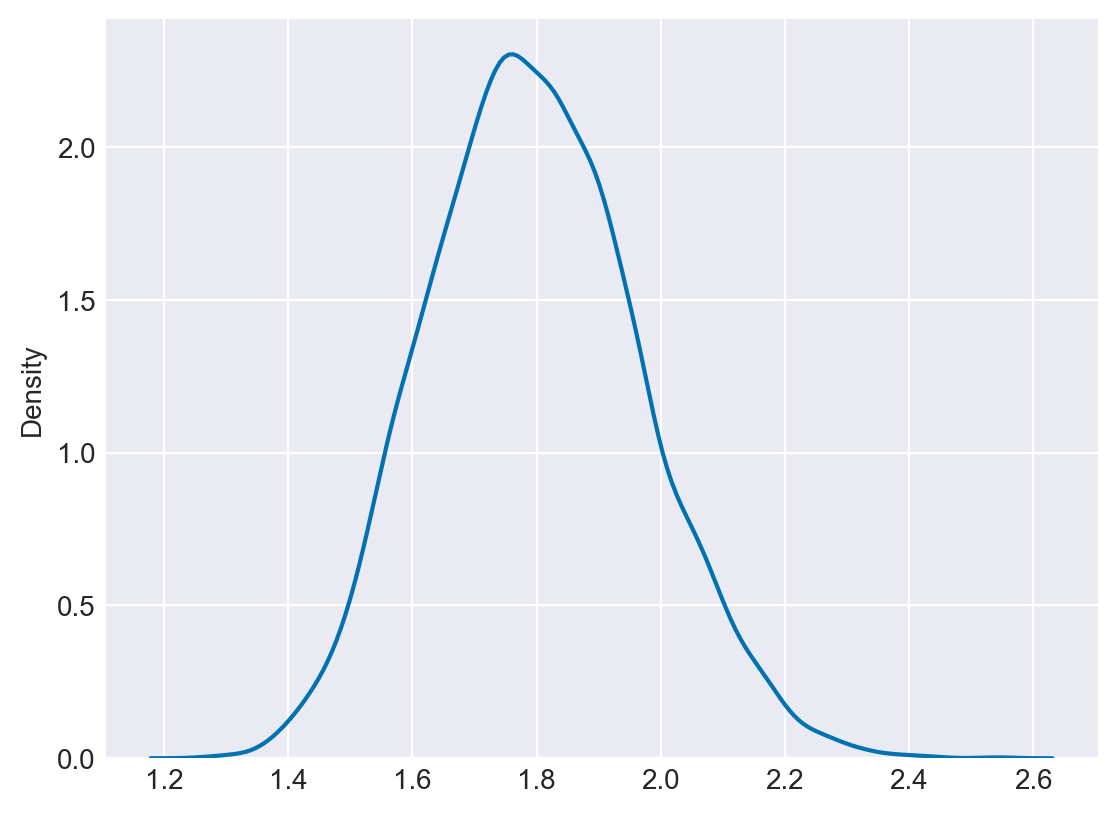

In [5]:
growth = np.array([(1 + np.random.uniform(0,.1, size = 12)).prod() for i in range(10000)])
sns.kdeplot(growth);

#### Code 4.4

In [6]:
big = np.array([(1 + np.random.uniform(0,.5, size = 12)).prod() for i in range(10000)])
small = np.array([(1 + np.random.uniform(0,.01, size = 12)).prod() for i in range(10000)])

#### Code 4.5

In [7]:
log_big = np.array([np.log(1 + np.random.uniform(0, .5, size=12)).sum() for i in range(10000)])

#### Code 4.6

In [8]:
w, n = 60, 90
p_grid = np.linspace(0, 1, 100) 
posterior = stats.binom.pmf(w,n,p_grid) * stats.uniform.pdf(p_grid, 0, 1) 
posterior = posterior / (posterior).sum() 

#### Code 4.7

In [9]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)

#### Code 4.8

In [10]:
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

#### Code 4.9

In [11]:
d.describe()

height      weight         age        male
count  544.000000  544.000000  544.000000  544.000000
mean   138.263596   35.610618   29.344393    0.472426
std     27.602448   14.719178   20.746888    0.499699
min     53.975000    4.252425    0.000000    0.000000
25%    125.095000   22.007717   12.000000    0.000000
50%    148.590000   40.057844   27.000000    0.000000
75%    157.480000   47.209005   43.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000

#### Code 4.10

In [12]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

#### Code 4.11

In [13]:
d2 = d[d.age >= 18]

#### Code 4.12

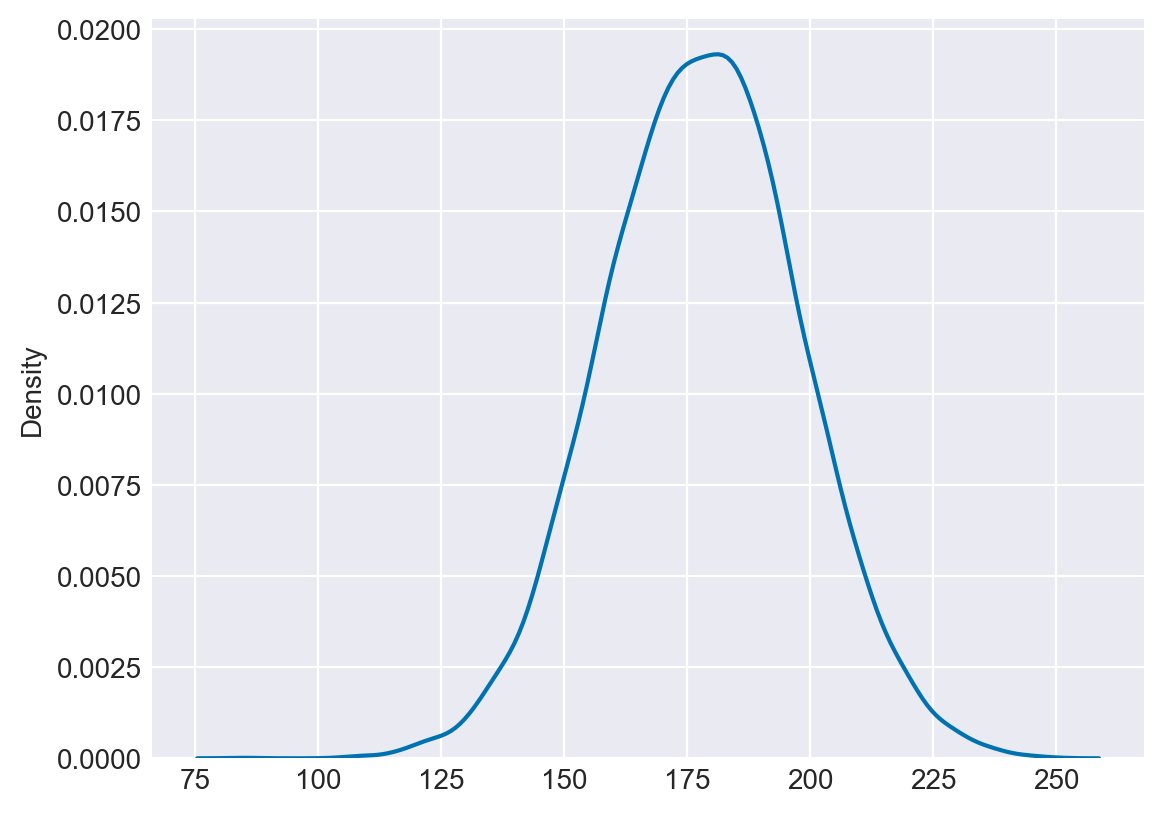

In [14]:
sns.kdeplot(np.random.normal(178, 20, size=10000));

#### Code 4.13

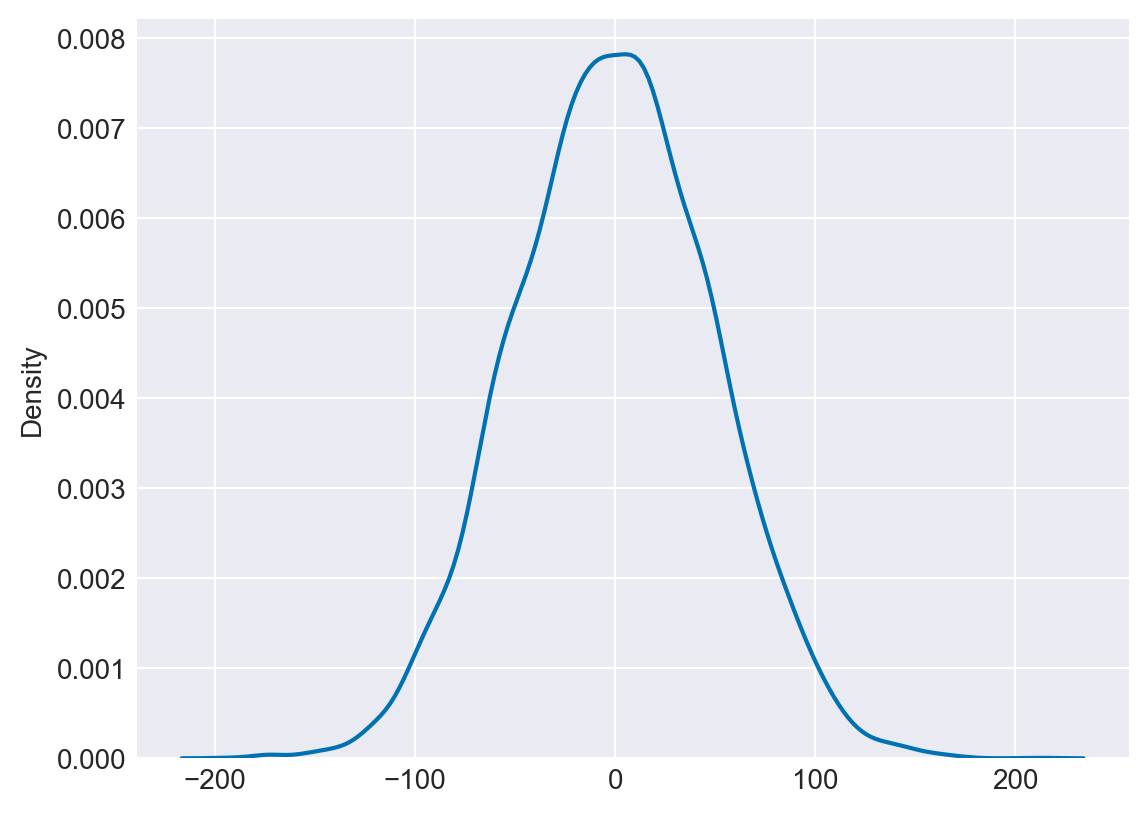

In [15]:
sns.kdeplot(np.random.normal(0, 50, size=10000));

#### Code 4.14

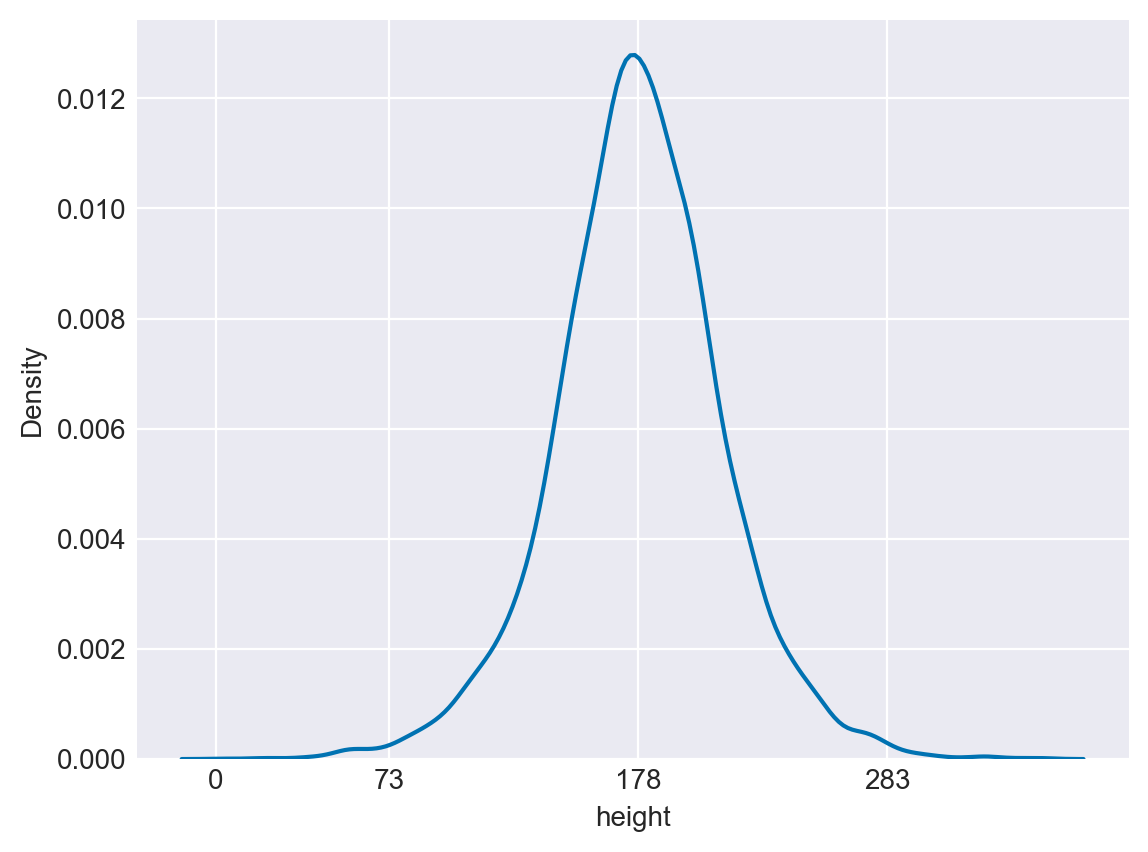

In [16]:
sample_mu = np.random.normal(178, 20, size=10000) 
sample_sigma = np.random.uniform(0,50, size=10000)
prior_h = np.random.normal(sample_mu, sample_sigma, size=10000)
ax = sns.kdeplot(prior_h)
ax.set_xlabel('height')
ax.set_ylabel('Density')
ax.set_xticks([0, 73, 178, 283]);


#### Code 4.15

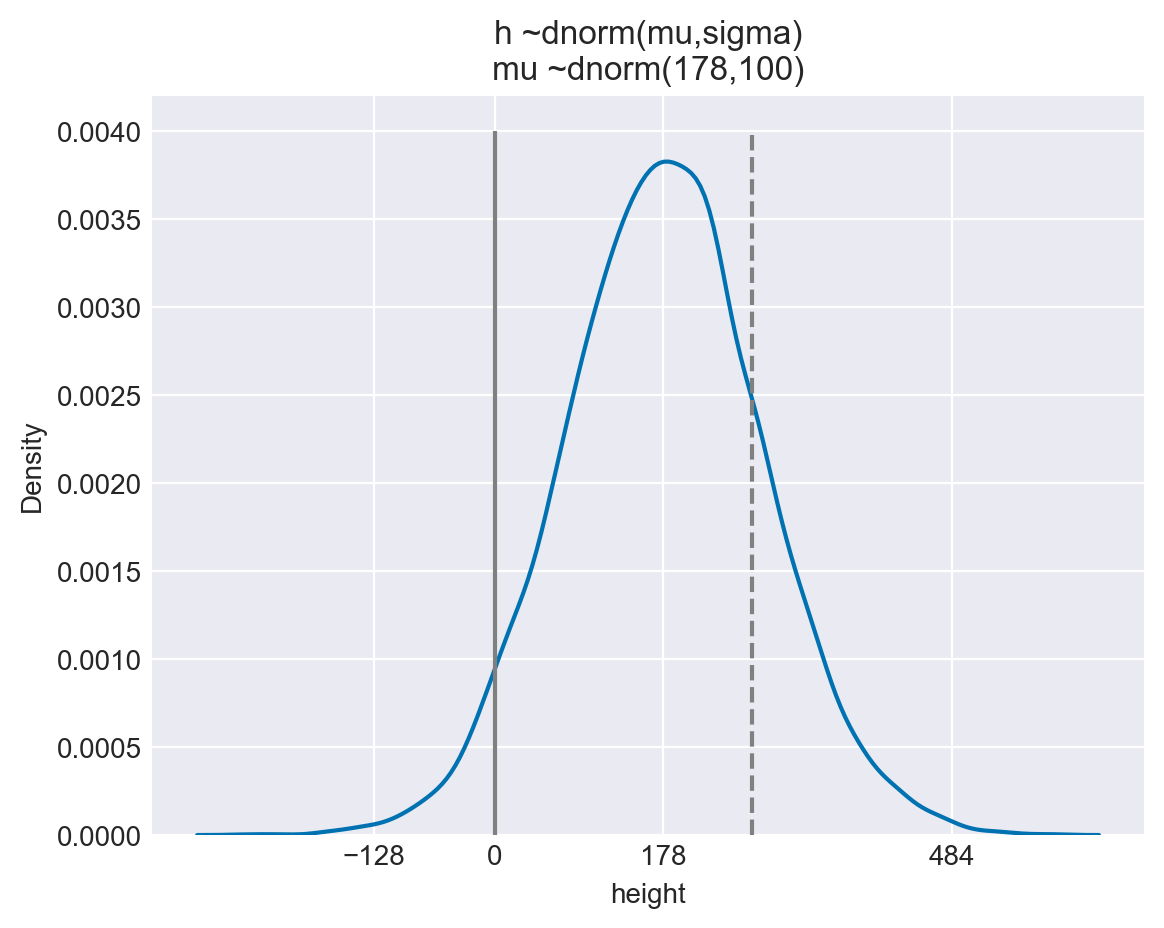

In [17]:
sample_mu = np.random.normal(178, 100, size=10000) 
sample_sigma = np.random.uniform(0,50, size=10000)
prior_h = np.random.normal(sample_mu, sample_sigma, size=10000)
ax = sns.kdeplot(prior_h)
ax.vlines(272, ymin = 0, ymax = 0.004, color='grey', linestyle='--')
ax.vlines(0, ymin = 0, ymax = 0.004, color='grey', linestyle='-')
ax.set_xlabel('height')
ax.set_ylabel('Density')
ax.set_xticks([-128, 0, 178, 484])
ax.set_title('h ~dnorm(mu,sigma)\nmu ~dnorm(178,100)');


#### Code 4.16

In [18]:
mu_list = np.linspace(150, 160, 100) 
sigma_list = np.linspace(7, 9, 100)

mu_grid, sigma_grid = np.meshgrid(mu_list, sigma_list)

mu = mu_grid.flatten()
sigma = sigma_grid.flatten() 

post_ll = np.array([
    np.sum(stats.norm.logpdf(d2['height'], mu, sigma))
    for mu, sigma in zip(mu, sigma)
])

post_prod = (post_ll + 
             stats.norm.logpdf(mu, loc=178, scale=20) + 
             stats.uniform.logpdf(sigma, loc=0, scale=50))

post_prob = np.exp(post_prod - max(post_prod)).reshape(mu_grid.shape)



#### Code 4.17

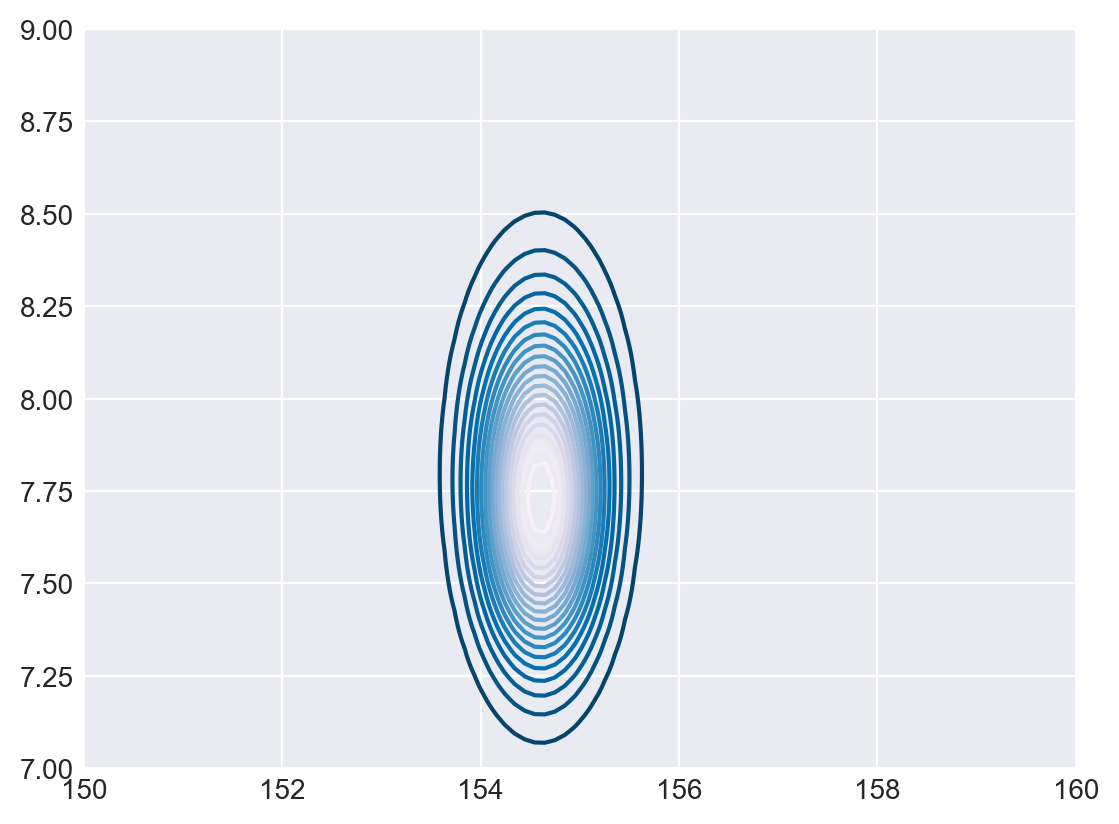

In [19]:
plt.contour(mu_grid, sigma_grid, post_prob, levels=20, cmap = 'PuBu_r');

#### Code 4.18

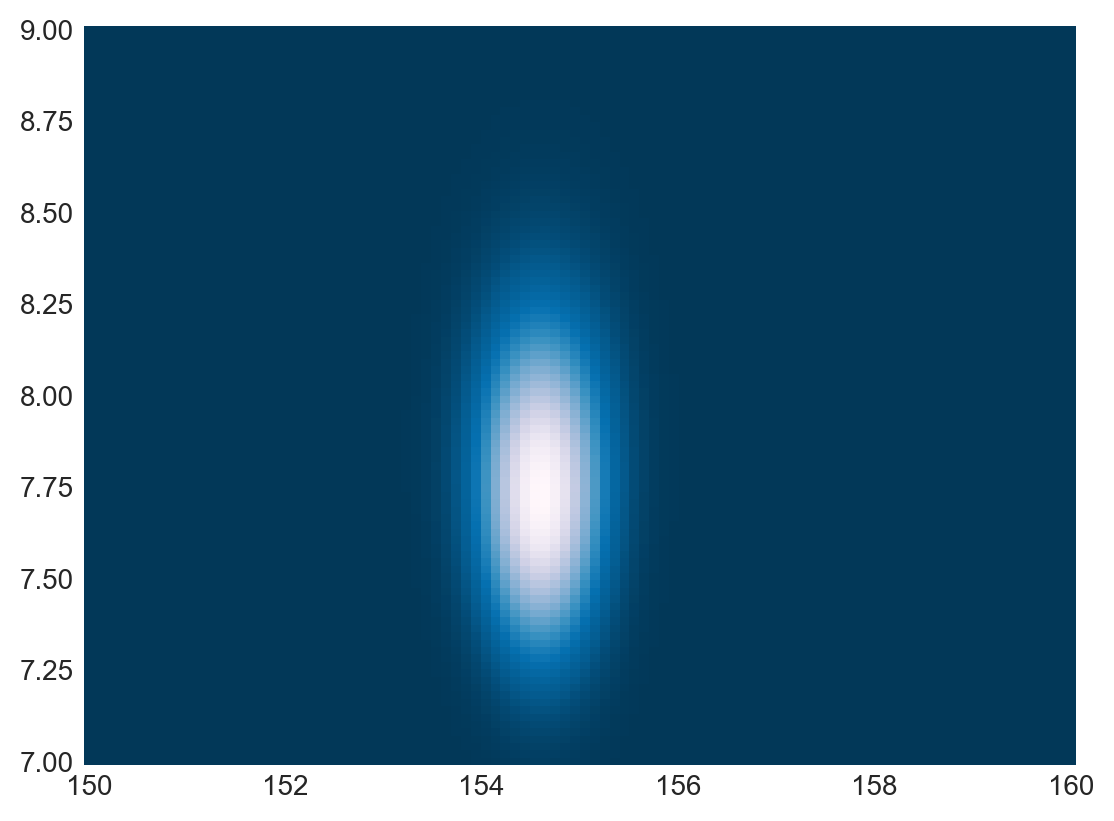

In [20]:
plt.pcolormesh(mu_grid, sigma_grid, post_prob, cmap='PuBu_r');

#### Code 4.19

In [21]:
sample_rows = np.random.choice(np.arange(len(mu)), size = int(1e4), replace = True, p = post_prob.flatten() / post_prob.flatten().sum())
sample_mu = mu[sample_rows]
sample_sigma = sigma[sample_rows]

#### Code 4.21

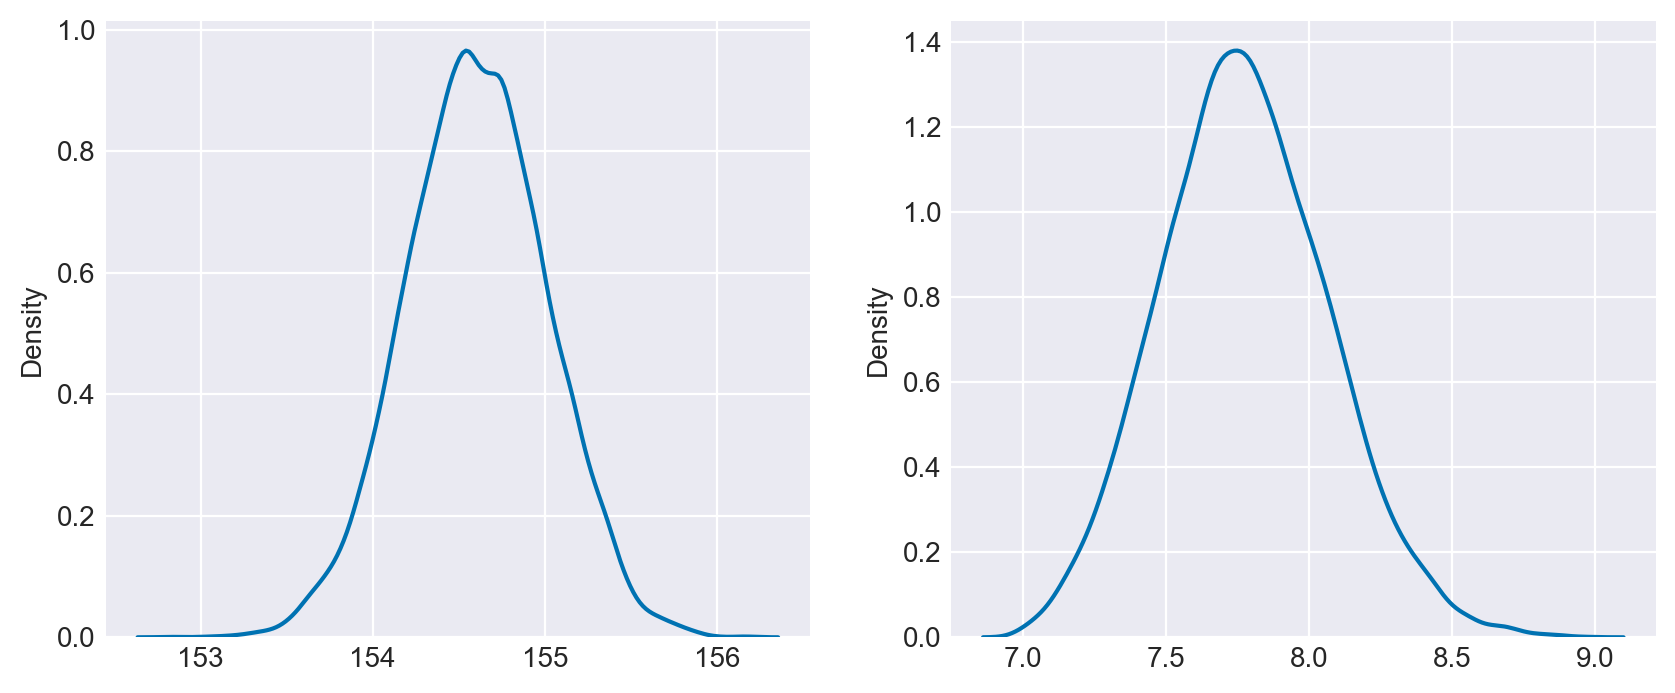

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.kdeplot(sample_mu, ax=ax[0]);
sns.kdeplot(sample_sigma, ax=ax[1]);


#### Code 4.22

In [23]:
display(np.percentile(sample_mu, [25, 75]))
np.percentile(sample_sigma, [25, 75])

array([154.34343434, 154.84848485])

array([7.56565657, 7.96969697])

#### Code 4.23

In [24]:
d3 = d2.sample(20, random_state=42)

#### Code 4.24

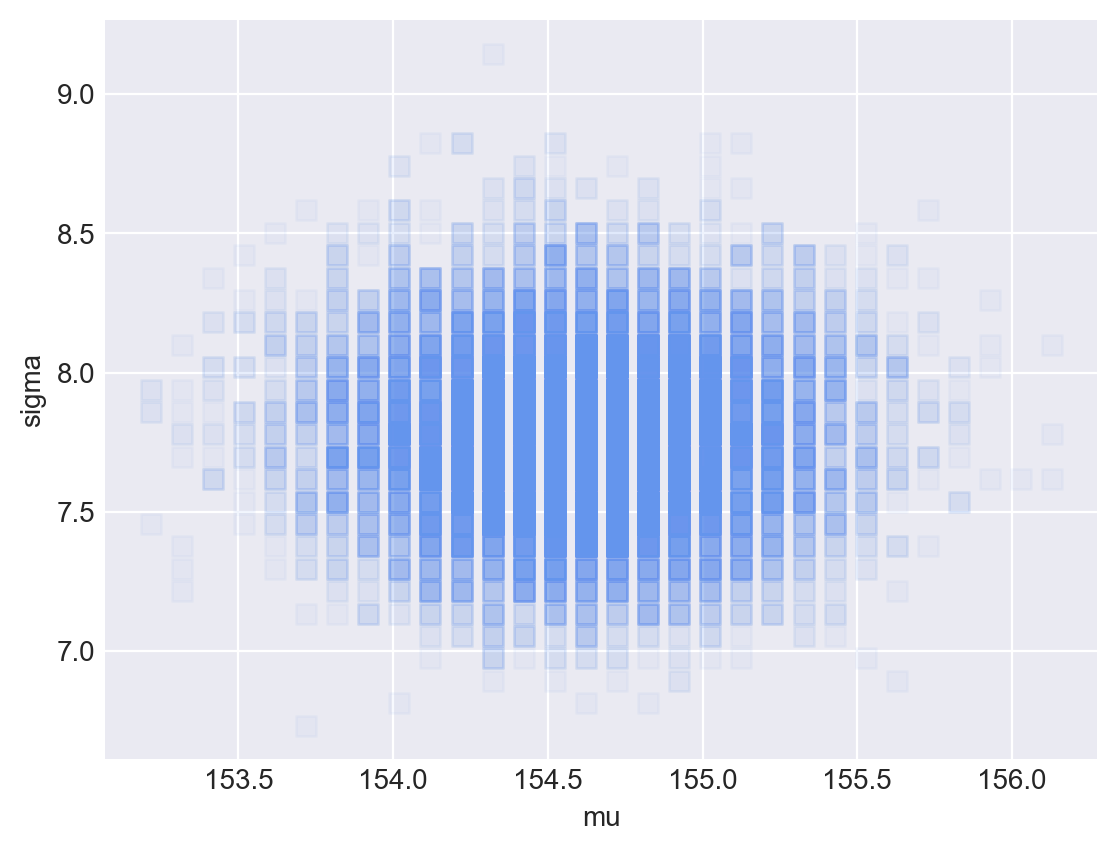

In [25]:
mu_list = np.linspace(150, 170, 200) 
sigma_list = np.linspace(4, 20, 200)

mu_grid, sigma_grid = np.meshgrid(mu_list, sigma_list)
mu_2 = mu_grid.flatten()
sigma_2 = sigma_grid.flatten()

post2_ll = [sum(stats.norm.logpdf(d2.height, loc=mu_2[i] , scale=sigma_2[i])) for i in range(len(mu_2))]

post2_prob = (post2_ll + 
             stats.norm.logpdf(mu_2, loc=178, scale=20) + 
             stats.uniform.logpdf(sigma_2, loc=0, scale=50))

post2_prob = np.exp(post2_prob - max(post2_prob)).reshape(mu_grid.shape)
post2_samples = np.random.choice(np.arange(len(mu_2)), size = int(1e4), replace = True, p = post2_prob.flatten() / post2_prob.flatten().sum())
sample_mu_2 = mu_2[post2_samples]
sample_sigma_2 = sigma_2[post2_samples]

plt.scatter(sample_mu_2, sample_sigma_2, marker='s', s = 50, alpha=0.05, color='cornflowerblue')
plt.xlabel('mu')
plt.ylabel('sigma');

#### Code 4.25

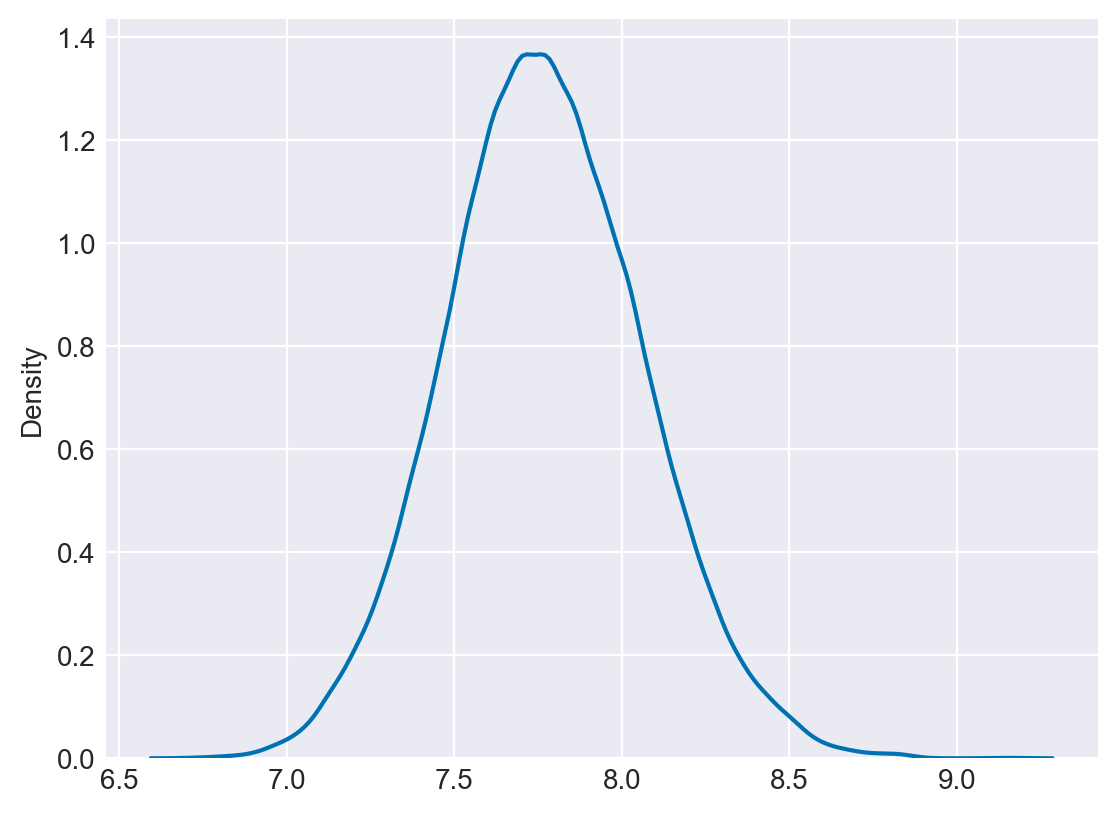

In [26]:
sns.kdeplot(sample_sigma_2);

#### Code 4.26

In [27]:
d2 = d[d.age >= 18] 

#### Code 4.27

In [28]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sigma=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2.height.values)


#### Code 4.28

In [29]:
with m4_1:
    trace_m4_1 = pm.sample(2000, tune=100, cores = 1, chains = 4)

# Im using 1 core because I'm getting a weird hanging error. This will run faster by either removing this core parameter or setting it to >1 (ideally 4).

Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

#### Code 4.29

In [ ]:
pm.summary(trace_m4_1, hdi_prob=.89)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     154.611  0.434   153.921    155.280      0.039    0.027     128.0   
sigma    7.753  0.275     7.303      8.164      0.014    0.010     380.0   

       ess_tail  r_hat  
mu        115.0   1.07  
sigma     283.0   1.00

#### Code 4.30

In [ ]:
with pm.Model() as start:
    mu = pm.Normal('mu', mu=178, sigma=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2.height.values)
    trace_start = pm.sample(1000, 
                            tune=1000, 
                            cores = 1,
                            chains = 4,
                            init_values = {'mu': d2.height.mean(), 'sigma': d2.height.std()})

    

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


#### Code 4.31

In [ ]:
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu=178, sigma=.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2.height.values)
    trace_m4_2 = pm.sample(1000, 
                            tune=1000, 
                            cores = 1,
                            chains = 4)
pm.summary(trace_m4_2, hdi_prob=.89)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     177.864  0.100   177.708    178.029      0.002    0.001    4310.0   
sigma   24.624  0.925    23.141     26.042      0.015    0.011    3718.0   

       ess_tail  r_hat  
mu       2723.0    1.0  
sigma    2721.0    1.0

#### Code 4.32

In [ ]:
trace_m4_1.posterior.to_dataframe().reset_index()[['mu', 'sigma']].cov()



mu     sigma
mu     0.164156  0.000114
sigma  0.000114  0.086862

#### Code 4.33

In [ ]:
display(np.diag(trace_m4_1.posterior.to_dataframe().reset_index()[['mu', 'sigma']].cov()))
display(trace_m4_1.posterior.to_dataframe().reset_index()[['mu', 'sigma']].corr())

array([0.16415563, 0.0868617 ])

mu     sigma
mu     1.000000  0.000958
sigma  0.000958  1.000000

#### Code 4.34

In [ ]:
post = trace_m4_1.posterior.to_dataframe().reset_index()[['mu', 'sigma']]
post.head()

mu     sigma
0  154.511480  7.608779
1  154.589488  7.793448
2  154.765616  7.957716
3  154.765616  7.957716
4  154.757935  7.893012

#### Code 4.35

In [ ]:
az.summary(trace_m4_1, hdi_prob=.89)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     154.608  0.405   153.956    155.243      0.010    0.007    1640.0   
sigma    7.769  0.295     7.267      8.214      0.003    0.002    7801.0   

       ess_tail  r_hat  
mu       1667.0    1.0  
sigma    6221.0    1.0

#### Code 4.36

In [ ]:
with pm.Model() as m4_1_logsigma:
    mu = pm.Normal('mu', mu=178, sigma=20)
    sigma = pm.Lognormal('sigma', mu=2, tau=0.01)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2.height)
    trace_4_1_logsigma = pm.sample(1000, tune=1000)

#### Code 4.37

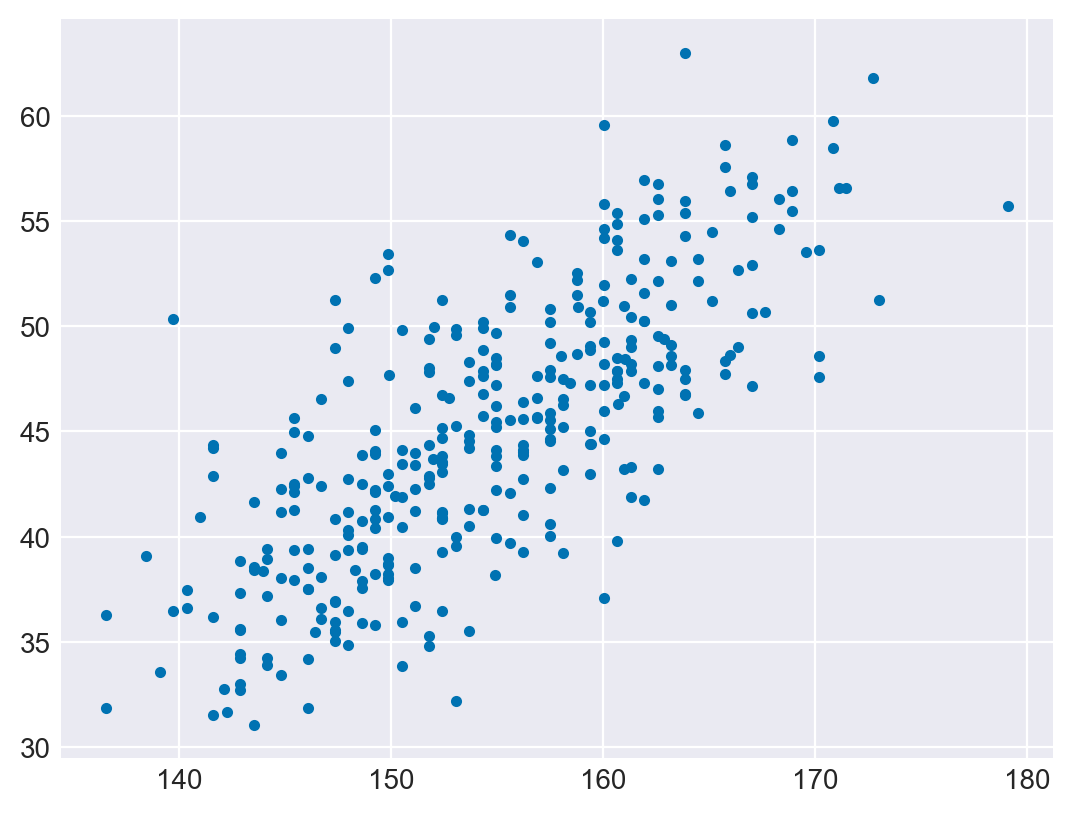

In [ ]:
plt.plot(d2.height, d2.weight, '.');

#### Code 4.38

In [ ]:
np.random.seed(2971)
N = 100
a = np.random.normal(178, 20, size=N)
b = np.random.normal(0, 10, size=N)


#### Code 4.39

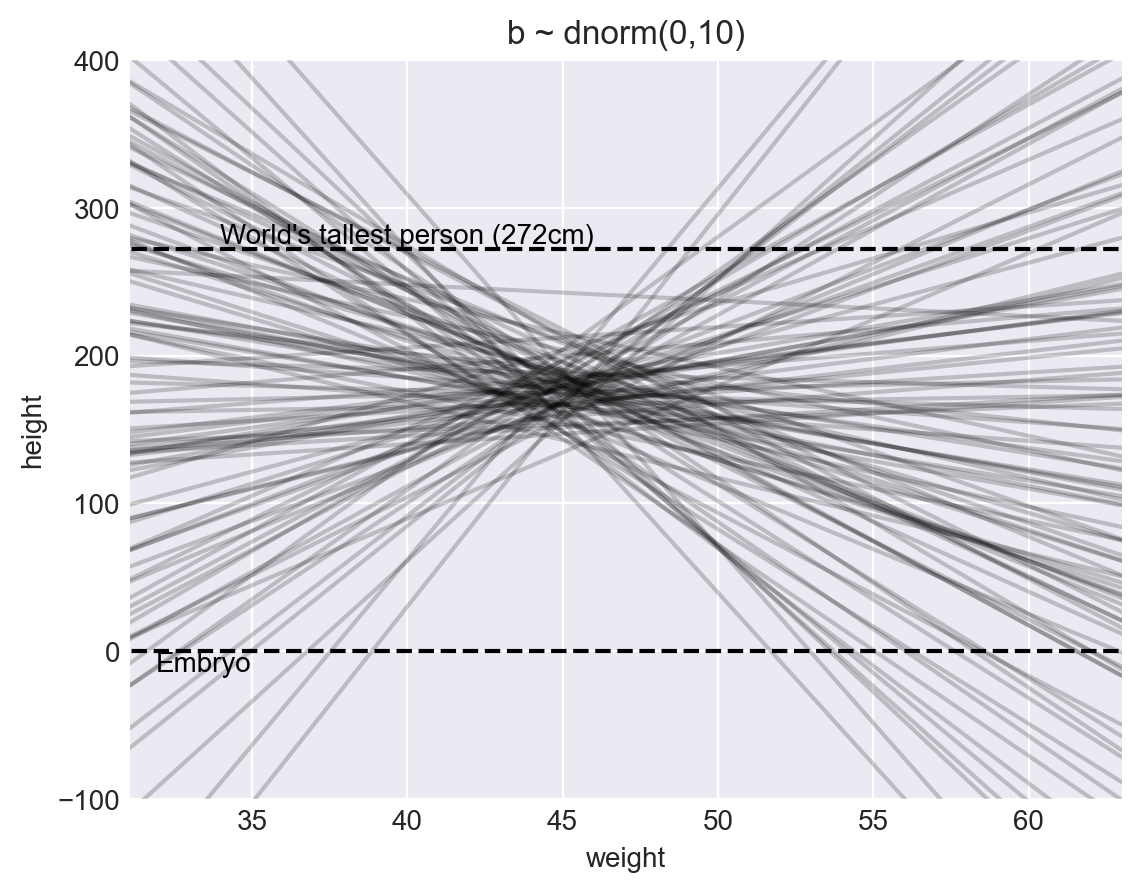

In [ ]:
x_range = np.linspace(d2.weight.min(), d2.weight.max(), N)
x_bar = d2.weight.mean()
for i in range(N):
    y = a[i] + b[i] * (x_range - x_bar)
    plt.plot(x_range, y, color='black', alpha=0.2)

plt.title("b ~ dnorm(0,10)")
plt.xlabel("weight")
plt.ylabel("height")
plt.vlines
plt.hlines(272, 0, 100, linestyles='dashed', color = 'black', label = 'World\'s tallest person (272cm)')
plt.text(46, 272, "World's tallest person (272cm)", color='black', 
         ha='right', va='bottom', fontsize=10)
plt.hlines(0, 0, 100, linestyles='dashed', color = 'black', label = 'Embryo')
plt.text(35, 0, 'Embryo', color='black', 
         ha='right', va='top', fontsize=10)
plt.xlim(d2.weight.min(), d2.weight.max())
plt.ylim(-100, 400)
plt.show()

#### Code 4.40

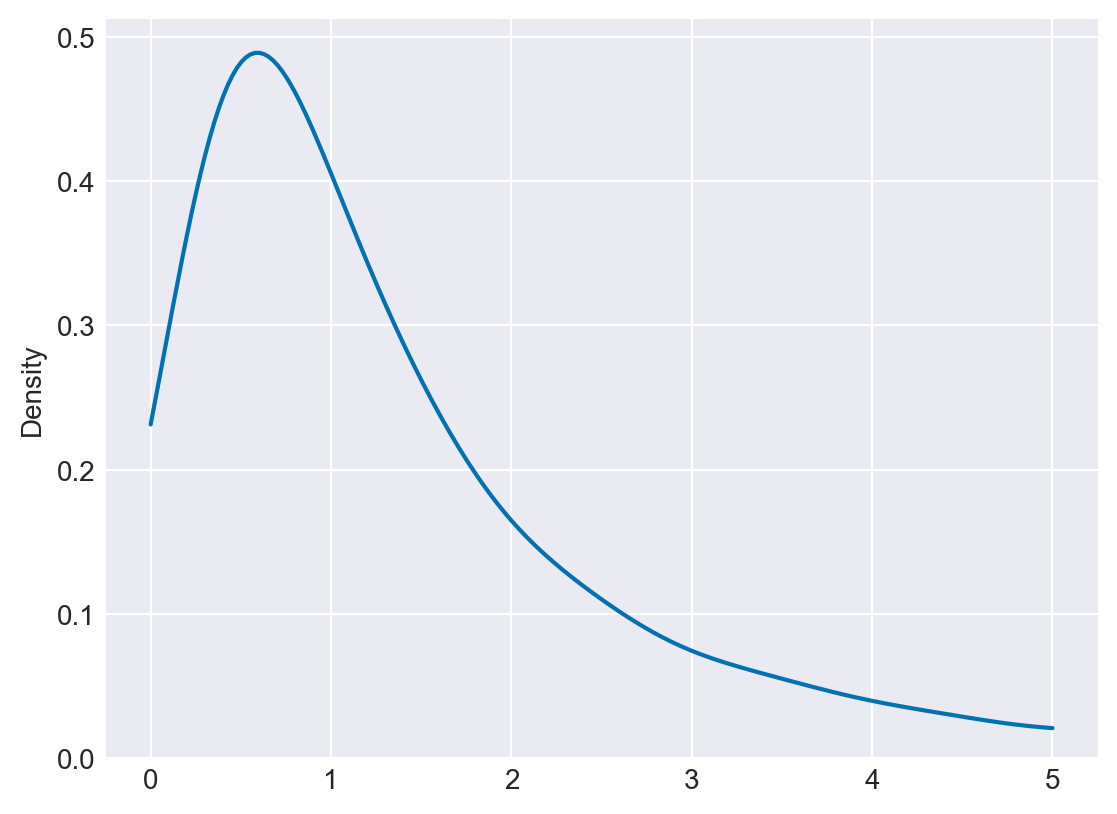

In [ ]:
b = np.random.lognormal(0, 1, size=int(1e4)) 
sns.kdeplot(b, clip=(0, 5));

#### Code 4.41

In [ ]:
np.random.seed(2971)
N = 100
a = np.random.normal(178, 20, size=N)
b = np.random.lognormal(0, 1, size=N)

#### Code 4.42

In [ ]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d2 = d[d.age >= 18]

x_bar = d2.weight.mean() 

with pm.Model() as m4_3: 
    sigma = pm.Uniform('sigma', 0, 50)
    b  = pm.Lognormal('b', 0, 1)
    a = pm.Normal('a', 178, 20)
    mu = pm.Deterministic('mu', a + b * (d2.weight - x_bar)) 
    height = pm.Normal(
        'height',
        mu = mu,
        sigma = sigma,
        observed = d2.height.values
    )
    trace_m4_3 = pm.sample(1000, tune=1000, cores = 1, chains = 4)

    display(az.summary(trace_m4_3.posterior[['a', 'b']], hdi_prob=.89))


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, b, a]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a  154.595  0.280   154.163    155.050      0.004    0.003    6003.0   
b    0.902  0.042     0.833      0.965      0.001    0.000    5124.0   

   ess_tail  r_hat  
a    3133.0    1.0  
b    2777.0    1.0

#### Code 4.43

In [ ]:
trace_m4_3.posterior.to_dataframe().reset_index().head(20)

chain  draw  mu_dim_0          a    sigma         b          mu
0       0     0         0  154.55039  5.15736  0.953406  157.253412
1       0     0         1  154.55039  5.15736  0.953406  146.441976
2       0     0         2  154.55039  5.15736  0.953406  142.036316
3       0     0         3  154.55039  5.15736  0.953406  162.226672
4       0     0         4  154.55039  5.15736  0.953406  151.009808
5       0     0         5  154.55039  5.15736  0.953406  171.713707
6       0     0         6  154.55039  5.15736  0.953406  148.117749
7       0     0         7  154.55039  5.15736  0.953406  164.551131
8       0     0         8  154.55039  5.15736  0.953406  144.901347
9       0     0         9  154.55039  5.15736  0.953406  163.605130
10      0     0        10  154.55039  5.15736  0.953406  159.226499
11      0     0        11  154.55039  5.15736  0.953406  150.955750
12      0     0        12  154.55039  5.15736  0.953406  146.009519
13      0     0        13  154.55039  5.15736  0.953406  157.133658
14      0     0        14  154.55039  5.15736  0.953406  143.928317
15      0     0        15  154.55039  5.15736  0.953406  157.956155
16      0     0        16  154.55039  5.15736  0.953406  152.009865
17      0     0        17  154.55039  5.15736  0.953406  148.225863
18      0     0        18  154.55039  5.15736  0.953406  158.361584
19      0     0        19  154.55039  5.15736  0.953406  152.388266

In [ ]:
with pm.Model() as m4_3b: 
    sigma = pm.Uniform('sigma', lower = 0, upper = 50)
    log_b  = pm.Normal('log_b', 0,1)
    a = pm.Normal('a', 178, 20)
    mu = pm.Deterministic('mu', a + np.exp(log_b) * (d2.weight.values - x_bar)) 
    height = pm.Normal(
        'height',
        mu = mu,
        sigma = sigma,
        observed = d2.height.values
    )
    trace_m4_3b= pm.sample(1000, tune=1000, cores = 1, chains = 4)

    display(az.summary(trace_m4_3b.posterior[['a', 'log_b']], hdi_prob=.89))



Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, log_b, a]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      154.609  0.277   154.167    155.059      0.003    0.002    7242.0   
log_b   -0.103  0.047    -0.182     -0.032      0.001    0.000    6356.0   

       ess_tail  r_hat  
a        3032.0    1.0  
log_b    3000.0    1.0

#### Code 4.4

In [ ]:
pm.summary(trace_m4_3.posterior[['a', 'b','sigma']], hdi_prob=.89)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      154.603  0.267   154.176    155.018      0.003    0.002    6197.0   
b        0.903  0.041     0.841      0.972      0.001    0.000    6222.0   
sigma    5.104  0.191     4.784      5.394      0.002    0.002    5996.0   

       ess_tail  r_hat  
a        3053.0    1.0  
b        2934.0    1.0  
sigma    2851.0    1.0

#### Code 4.45

In [ ]:
round(trace_m4_3.posterior.to_dataframe().reset_index()[['a', 'b', 'sigma']].cov(),3)

a      b  sigma
a      0.071  0.000 -0.000
b      0.000  0.002 -0.000
sigma -0.000 -0.000  0.036

#### Code 4.46

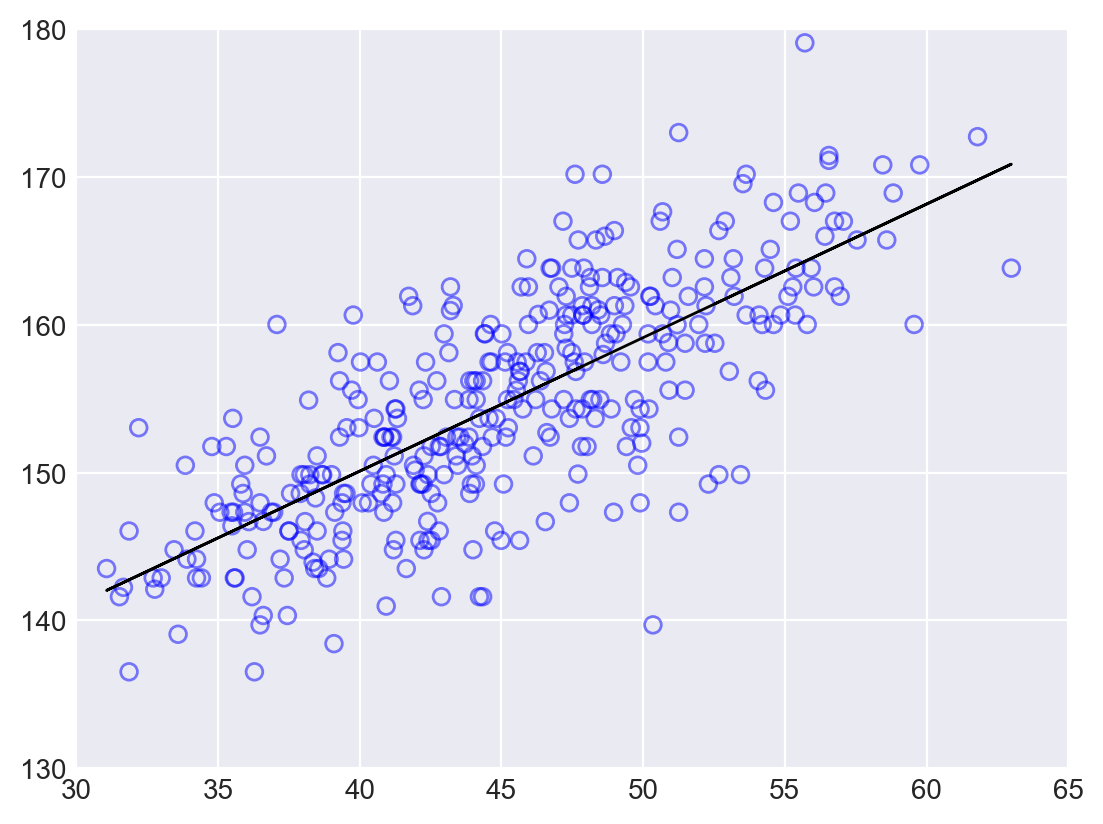

In [ ]:
plt.scatter(d2.weight, d2.height, marker='o', edgecolor='blue', alpha=0.5, facecolor='none')
plt.xlim(30,65)
plt.ylim(130, 180)
post = trace_m4_3.posterior.to_dataframe().reset_index()
a_map = post['a'].mean() 
b_map = post['b'].mean()  
plt.plot(d2.weight,a_map + b_map * (d2.weight - x_bar), color='black', lw=1);

#### Code 4.47

In [ ]:
post = trace_m4_3.posterior.to_dataframe().reset_index()[['a','b','sigma']].drop_duplicates().reset_index(drop=True)
post.head()


a         b     sigma
0  154.550390  0.953406  5.157360
1  154.664434  0.856617  5.006079
2  154.748766  0.971640  4.984813
3  154.907278  0.969652  5.049137
4  154.279105  0.842821  5.126035

#### Code 4.48

In [ ]:
N = 10 #Change this to watch the lines converge [10, 50, 150, 352]
dN = d2.iloc[:N, :]
with pm.Model() as mN:
    sigma = pm.Uniform('sigma', 0, 50)
    b  = pm.Lognormal('b', 0, 1)
    a = pm.Normal('a', 178, 20)
    mu = pm.Deterministic('mu', a + b * (dN.weight - dN.weight.mean()))
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=dN.height.values)
    trace_N = pm.sample(1000, tune=1000, cores = 1, chains = 4)

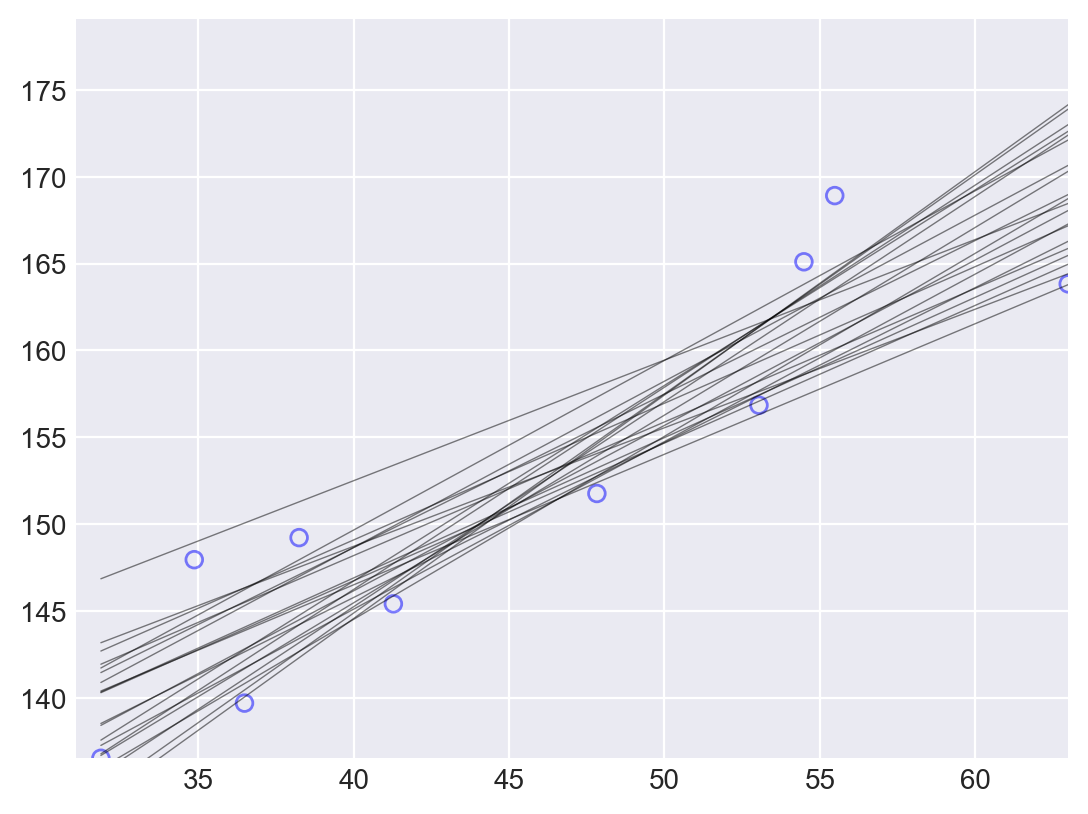

In [ ]:
plt.scatter(dN.weight, dN.height, marker='o', edgecolor='blue', alpha=0.5, facecolor='none')
plt.xlim(d2.weight.min(), d2.weight.max())
plt.ylim(d2.height.min(), d2.height.max())
post = trace_N.posterior.to_dataframe().reset_index()[['a','b','sigma']].drop_duplicates().reset_index(drop=True)
x_range = np.linspace(dN.weight.min(), dN.weight.max(), 100)
for i in range(20):
    plt.plot(x_range,post['a'][i] + post['b'][i] * (x_range - dN.weight.mean()), color='black', lw=.5, alpha=.5);


#### Code 4.50

In [ ]:
post = trace_m4_3.posterior.to_dataframe().reset_index()[['a','b','sigma']].drop_duplicates().reset_index(drop=True)
mu_at_50 = post.a + post.b * (50 - x_bar)

#### Code 4.51

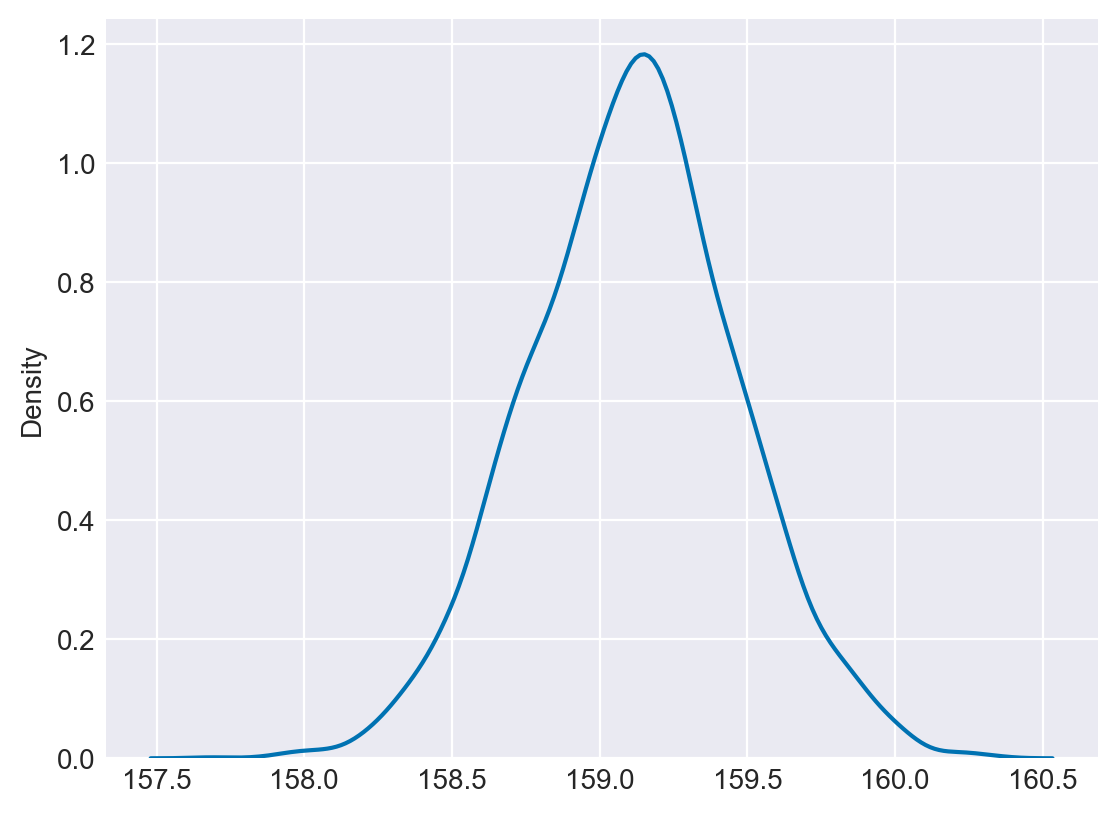

In [ ]:
sns.kdeplot(mu_at_50);

#### Code 4.52

In [ ]:
pd.DataFrame(
    np.quantile(mu_at_50, [0.055, 0.945]).reshape(1, -1),
    columns=['5.5%', '94.5%']
)

5.5%       94.5%
0  158.541982  159.679237

#### Code 4.53

In [ ]:
mu =  trace_m4_3.posterior['mu'][np.random.randint(0,4),:].values

#### Code 4.54

(135.0, 180.0)

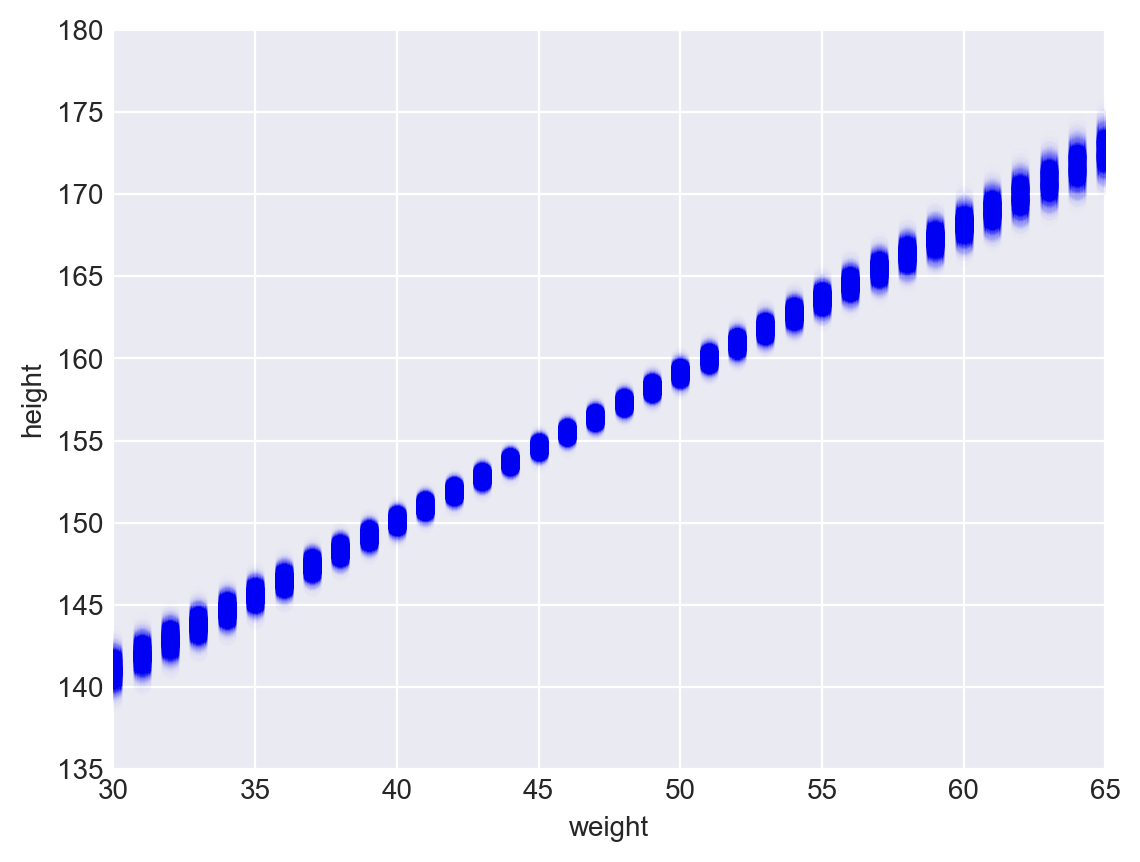

In [ ]:
weight_seq = np.arange(25, 71)

m4_4_traces = trace_m4_3.posterior[['a','b']].sel(chain = np.random.randint(0,4))
mu = np.zeros((len(weight_seq),m4_4_traces.sizes["draw"]))

for i, w in enumerate(weight_seq):
    mu[i] = m4_4_traces['a'] + m4_4_traces['b'] * (w - x_bar)


#We'll plot this again below but this is just to show how it looks
plt.plot(weight_seq, mu, 'o', color = 'blue', alpha = .002);
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim(30,65)
plt.ylim(135,180)

#### Code 4.56

In [ ]:
mu_mean = mu.mean(1)
mu_pi= az.hdi(mu.T, hdi_prob= .89)


/var/folders/5b/bs0n2tqj0c5_11dyn61ygmr00000gn/T/ipykernel_18358/2125997917.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_pi= az.hdi(mu.T, hdi_prob= .89)


#### Code 4.57

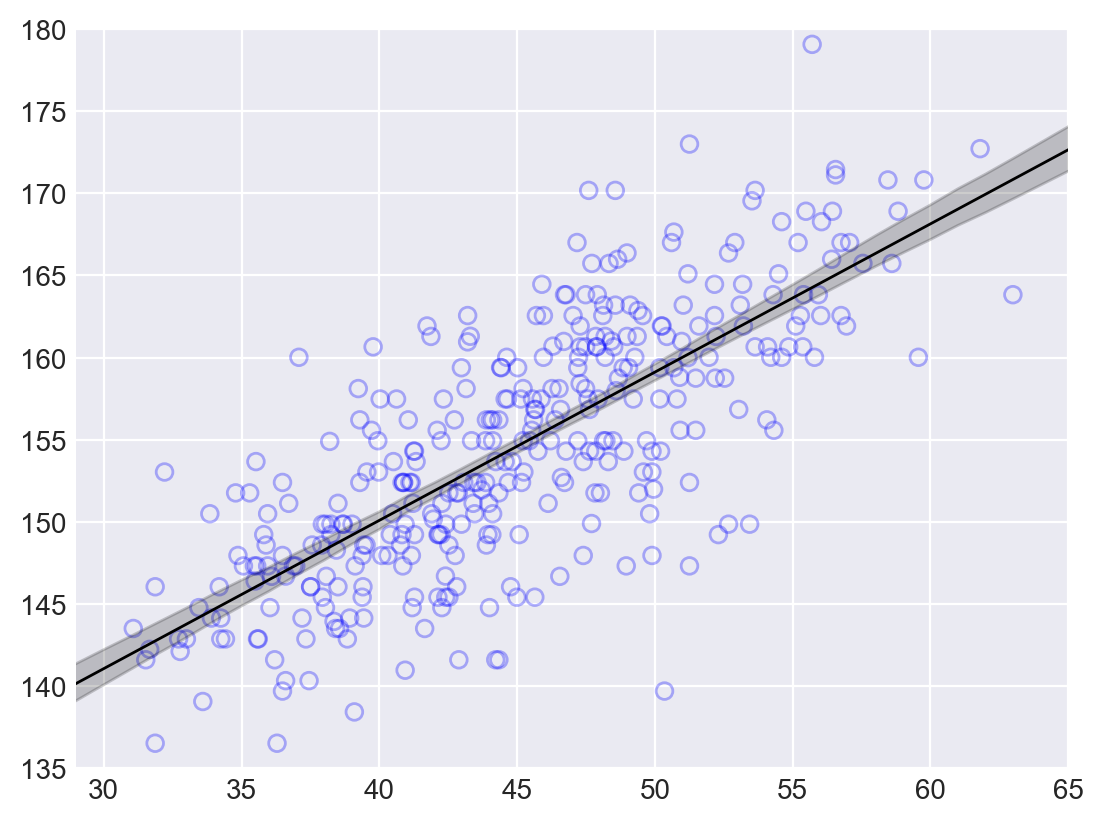

In [ ]:
plt.scatter(d2.weight, d2.height, edgecolor = 'blue', facecolor = 'none', alpha = .3);
plt.plot(weight_seq, mu_mean, color = 'black', lw = 1);
plt.fill_between(weight_seq, mu_pi[:,0], mu_pi[:,1], color = 'black', alpha = .2)
plt.xlim(29,65)
plt.ylim(135,180);

#### Code 4.58

_This is just describing the link function that we don't even use so I'll skip it for now._

#### Code 4.59

In [ ]:
weight_seq = np.arange(25, 71)

m4_4_traces = trace_m4_3.posterior[['a','b','sigma']].sel(chain = np.random.randint(0,4))
mu = np.zeros((len(weight_seq),m4_4_traces.sizes["draw"]))

for i, w in enumerate(weight_seq):
    mu[i] = m4_4_traces['a'] + m4_4_traces['b'] * (w - x_bar)

sim_height = np.random.normal(mu, m4_4_traces['sigma'])

(46, 1000)


#### Code 4.60

In [ ]:
height_pi = pd.DataFrame(
    np.quantile(sim_height, [0.055, 0.945]).reshape(1, -1),
    columns=['5.5%', '94.5%']
)
height_pi= az.hdi(sim_height.T, hdi_prob= .89)


/var/folders/5b/bs0n2tqj0c5_11dyn61ygmr00000gn/T/ipykernel_18358/3281751627.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  height_pi= az.hdi(sim_height.T, hdi_prob= .89)


#### Code 4.61

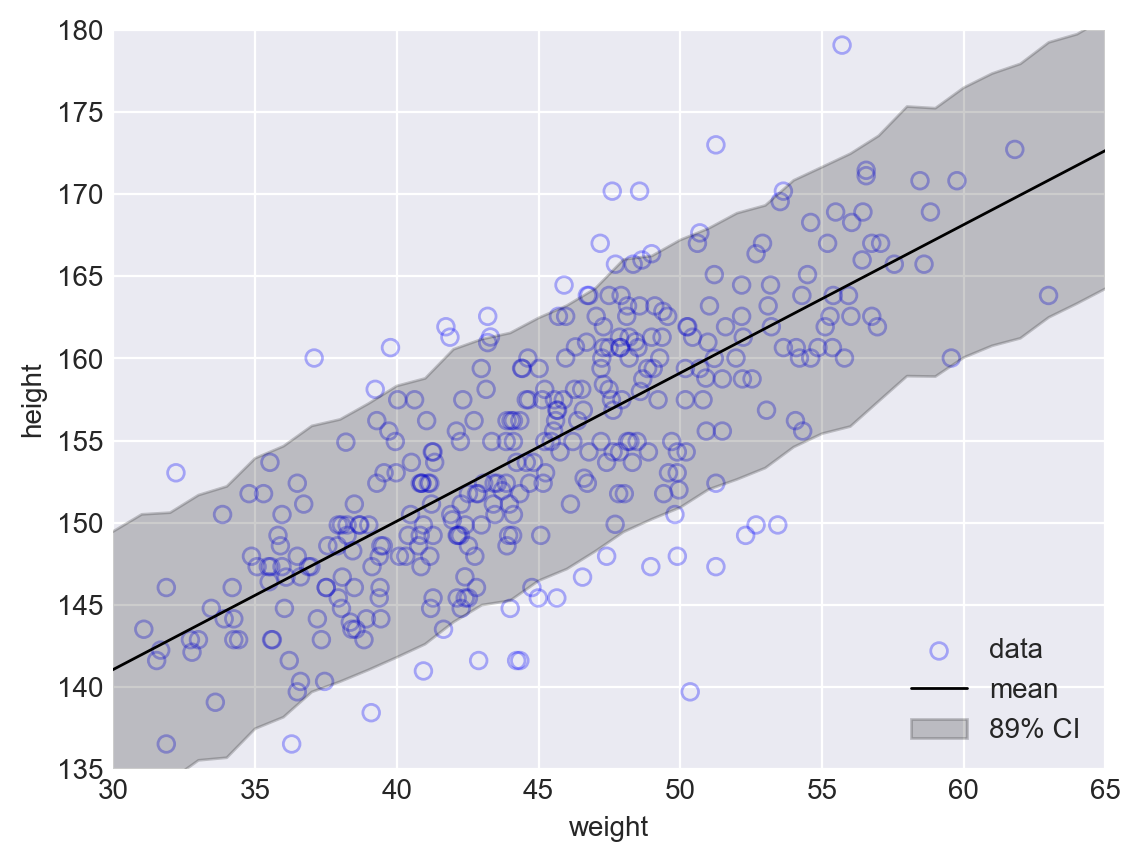

In [ ]:
plt.scatter(d2.weight, d2.height, marker='o', edgecolor='blue', facecolors='none', alpha=.3, label='data')
plt.xlabel('weight')
plt.ylabel('height')
plt.plot(weight_seq, mu_mean, color='black', lw=1, label='mean')
plt.fill_between(weight_seq, height_pi[:,0], height_pi[:,1], color='black', alpha=.2, label='89% CI')
plt.legend(loc='lower right')
plt.xlim(30,65)
plt.ylim(135,180);

#### Code 4.62

In [ ]:
weight_seq = np.arange(25, 71)
sample_size = 4000

m4_4_traces = trace_m4_3.posterior[['a','b','sigma']].to_dataframe().reset_index().sample(sample_size)
mu = np.zeros((len(weight_seq),m4_4_traces.shape[0]))

for i, w in enumerate(weight_seq):
    mu[i] = m4_4_traces['a'] + m4_4_traces['b'] * (w - x_bar)

sim_height = np.random.normal(mu, m4_4_traces['sigma'])

height_pi= az.hdi(sim_height.T, hdi_prob= .89)


/var/folders/5b/bs0n2tqj0c5_11dyn61ygmr00000gn/T/ipykernel_18358/4175816275.py:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  height_pi= az.hdi(sim_height.T, hdi_prob= .89)


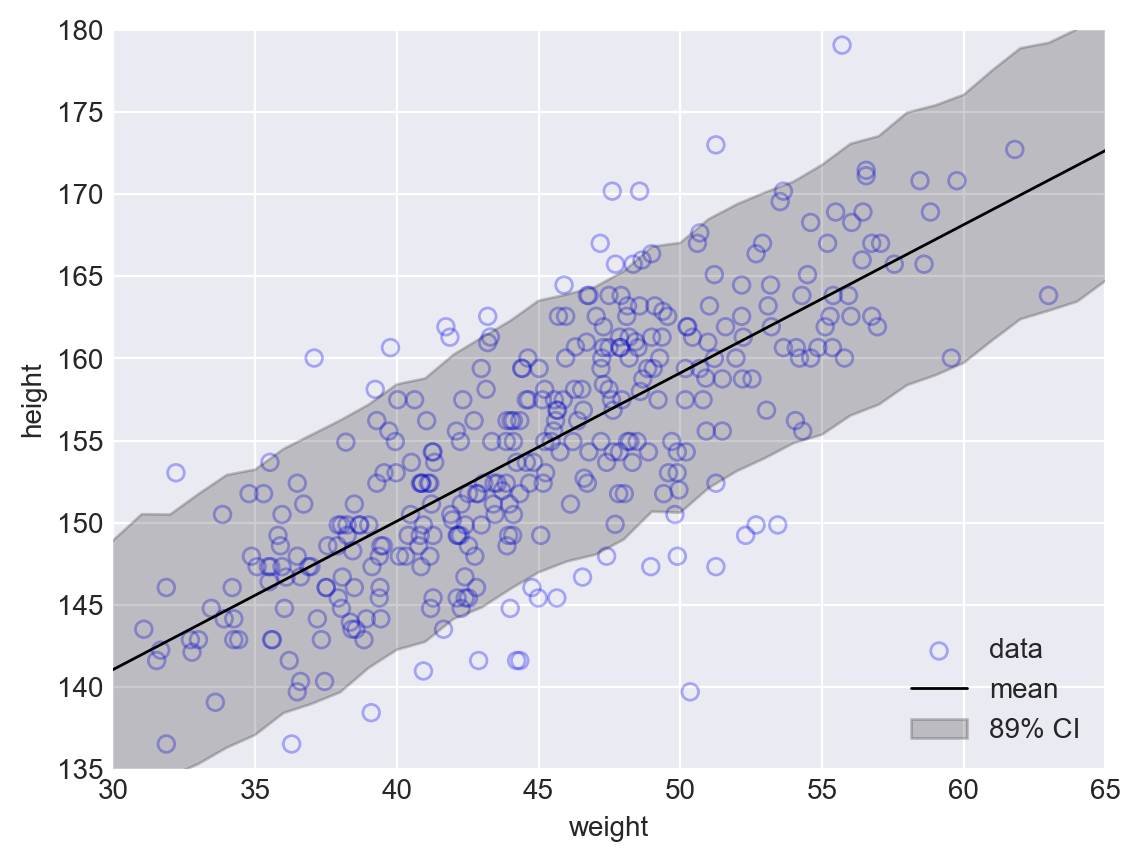

In [ ]:
plt.scatter(d2.weight, d2.height, marker='o', edgecolor='blue', facecolors='none', alpha=.3, label='data')
plt.xlabel('weight')
plt.ylabel('height')
plt.plot(weight_seq, mu_mean, color='black', lw=1, label='mean')
plt.fill_between(weight_seq, height_pi[:,0], height_pi[:,1], color='black', alpha=.2, label='89% CI')
plt.legend(loc='lower right')
plt.xlim(30,65)
plt.ylim(135,180);

#### Code 4.63

_This is a description of the sim function in R.  We'll just be using the variables and process instead so we'll skip this code block for now._


#### Code 4.64

In [ ]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d.head()
#plt.plot(d.weight, d.height, '.');

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

#### Code 4.65

In [ ]:
d['weight_s'] = (d.weight - d.weight.mean()) / d.weight.std()
d['weight_s2'] = d.weight_s ** 2


with pm.Model() as m4_5: 
    sigma = pm.Uniform('sigma', 0, 50)
    b1  = pm.Lognormal('b1', 0, 1)
    b2 = pm.Normal('b2', 0, 1)
    a = pm.Normal('a', 178, 20)
    mu = pm.Deterministic('mu', a + (b1 * d['weight_s']) + (b2 * d['weight_s2'])) 
    height = pm.Normal(
        'height',
        mu = mu,
        sigma = sigma,
        observed = d.height.values
    )
    trace_m4_5 = pm.sample(1000, tune=1000, cores = 1, chains = 4)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, b1, b2, a]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


#### Code 4.66

In [ ]:
pm.summary(trace_m4_5.posterior[['a', 'b1', 'b2', 'sigma']], hdi_prob=.89)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a      146.050  0.364   145.453    146.624      0.007    0.005    2669.0   
b1      21.738  0.290    21.257     22.188      0.005    0.004    2843.0   
b2      -7.797  0.271    -8.252     -7.397      0.005    0.004    2579.0   
sigma    5.799  0.175     5.520      6.081      0.003    0.002    2992.0   

       ess_tail  r_hat  
a        2522.0    1.0  
b1       2726.0    1.0  
b2       2672.0    1.0  
sigma    2748.0    1.0

#### Code 4.67

In [ ]:
weight_seq = np.linspace(-2.2, 2, 30)
m4_5_data = trace_m4_5.posterior[['a', 'b1', 'b2', 'sigma']].to_dataframe().reset_index()
mu = np.zeros((len(weight_seq),m4_5_data.shape[0]))

for i, w in enumerate(weight_seq):
    mu[i] = m4_5_data['a'] + (m4_5_data['b1'] * w) + (m4_5_data['b2'] * w**2)

height_pred = np.random.normal(mu, m4_5_data['sigma'])
height_pi = az.hdi(height_pred.T, hdi_prob=.89)
height_mean = height_pred.mean(0)
mu_mean = mu.mean(1)

#### Code 4.68

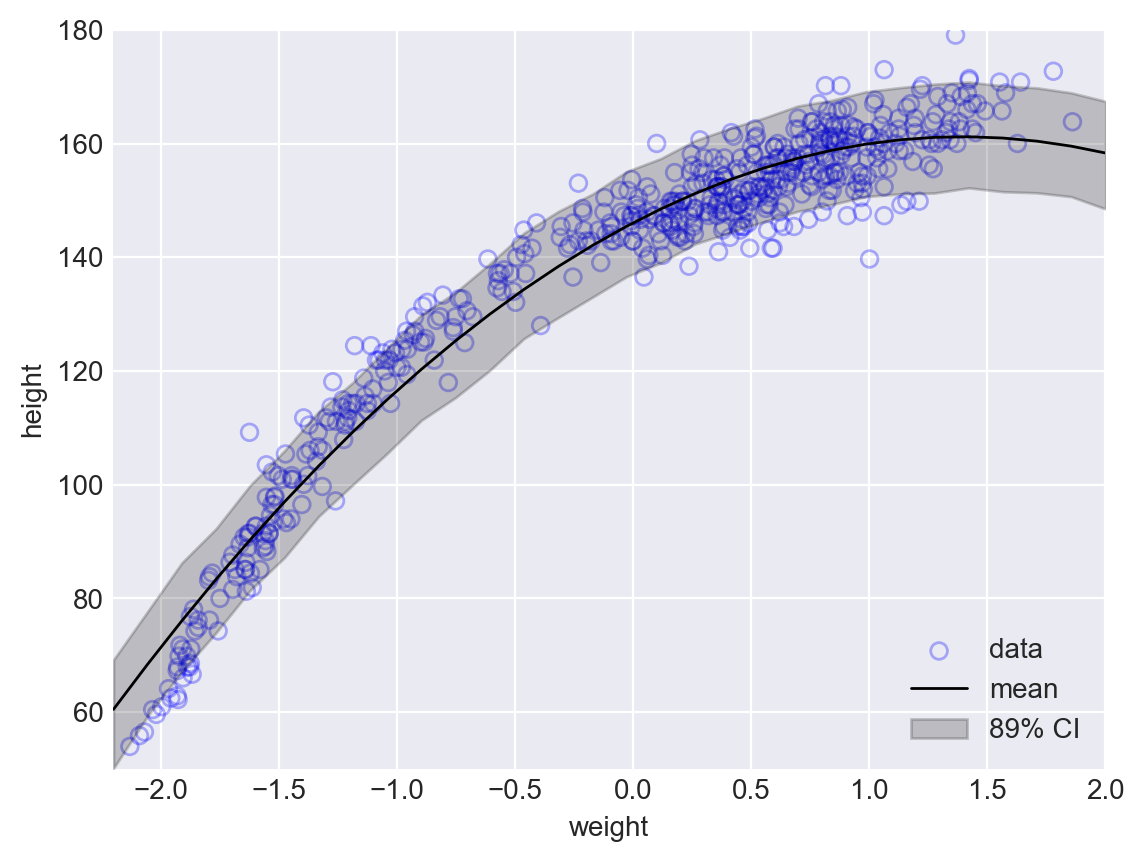

In [ ]:
plt.scatter(d.weight_s, d.height, marker='o', edgecolor='blue', facecolors='none', alpha=.3, label='data')
plt.xlabel('weight')
plt.ylabel('height')
plt.plot(weight_seq, mu_mean, color='black', lw=1, label='mean')
plt.fill_between(weight_seq, height_pi[:,0], height_pi[:,1], color='black', alpha=.2, label='89% CI')
plt.legend(loc='lower right')
plt.xlim(-2.2, 2)
plt.ylim(50,180);

#### Code 4.69

In [ ]:
d['weight_s3'] = d.weight_s ** 3
with pm.Model() as m4_6:
    sigma = pm.Uniform('sigma', 0, 50)
    b1  = pm.Lognormal('b1', 0, 1)
    b2 = pm.Normal('b2', 0, 1)
    b3 = pm.Normal('b3', 0, 1)
    a = pm.Normal('a', 178, 20)
    mu = pm.Deterministic('mu', a + (b1 * d['weight_s']) + (b2 * d['weight_s2']) + (b3 * d['weight_s3']))
    height = pm.Normal(
        'height',
        mu = mu,
        sigma = sigma,
        observed = d.height.values
    )
    trace_m4_6 = pm.sample(1000, tune=1000, cores = 1, chains = 4)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, b1, b2, b3, a]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [height]


Output()

#### Code 4.70

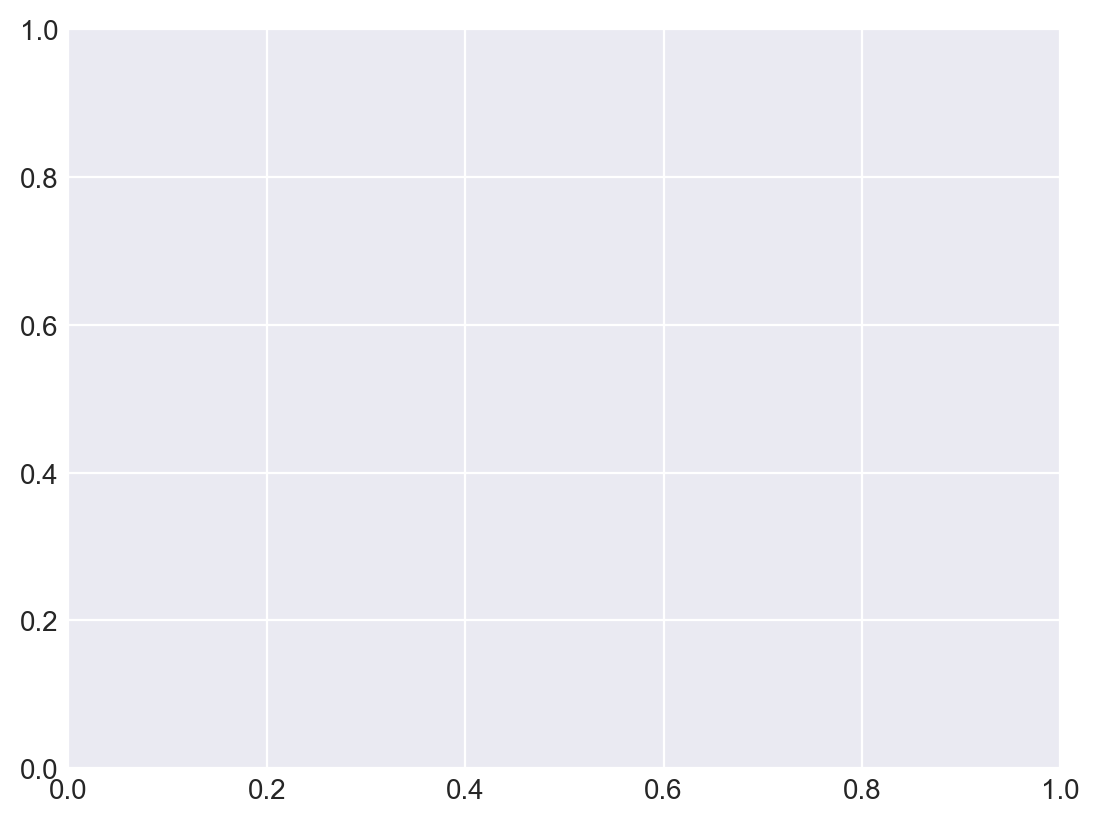

In [ ]:
ax = plt.gca() 
xticks = ax.get_xticks() 

#### Code 4.71

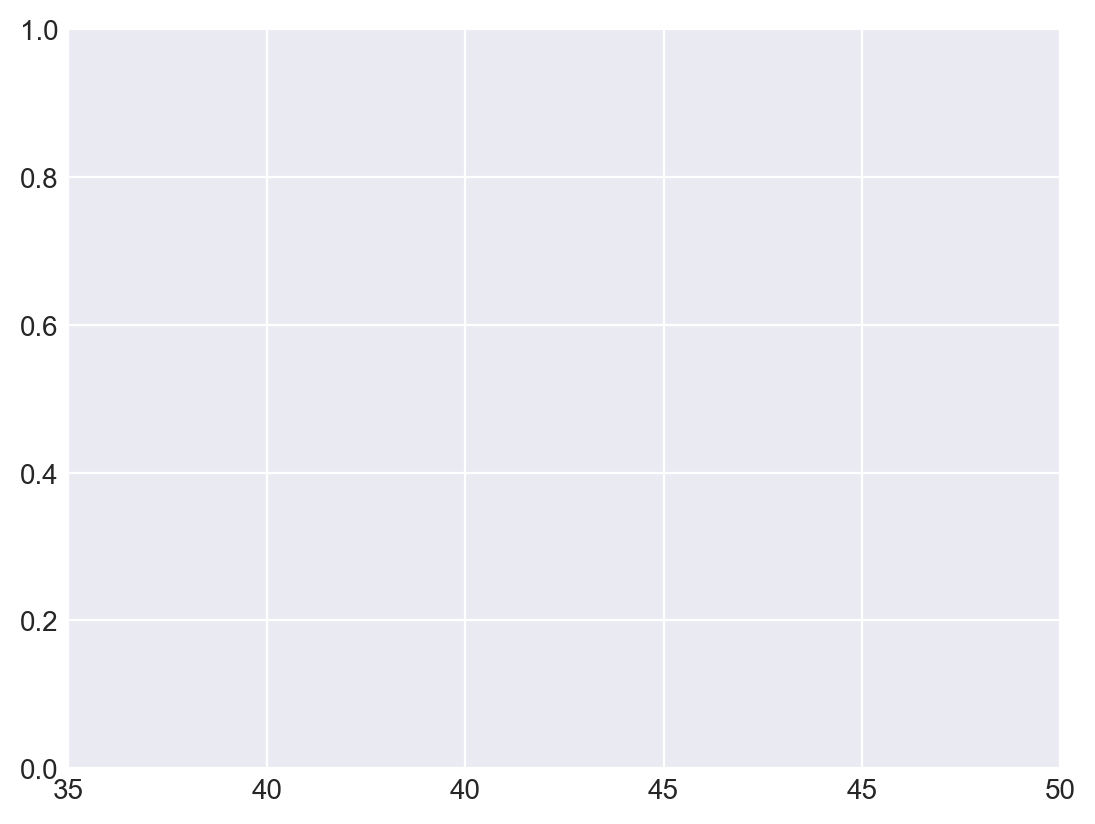

In [ ]:
x_ticks_natural = xticks * d.weight.std() + d.weight.mean() 
x_ticks_rounded = np.round(np.array(x_ticks_natural) / 5) * 5
plt.xticks(xticks, [f'{x:.0f}' for x in x_ticks_rounded]);

#### Code 4.72

In [30]:
d = pd.read_csv('data/cherryblossoms.csv', sep=';')
d.describe()
#plt.plot(d.year, d.temp, '.');

year         doy         temp   temp_upper   temp_lower
count  1215.000000  827.000000  1124.000000  1124.000000  1124.000000
mean   1408.000000  104.540508     6.141886     7.185151     5.098941
std     350.884596    6.407036     0.663648     0.992921     0.850350
min     801.000000   86.000000     4.670000     5.450000     0.750000
25%    1104.500000  100.000000     5.700000     6.480000     4.610000
50%    1408.000000  105.000000     6.100000     7.040000     5.145000
75%    1711.500000  109.000000     6.530000     7.720000     5.542500
max    2015.000000  124.000000     8.300000    12.100000     7.740000

#### Code 4.73

In [31]:
d2 = d.dropna(subset=['temp']) 
num_knots = 15 
knot_list = np.percentile(d2.year, np.linspace(0, 100, num_knots + 2))[1:-1]

#### Code 4.74

In [32]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list},
)

#### Code 4.75

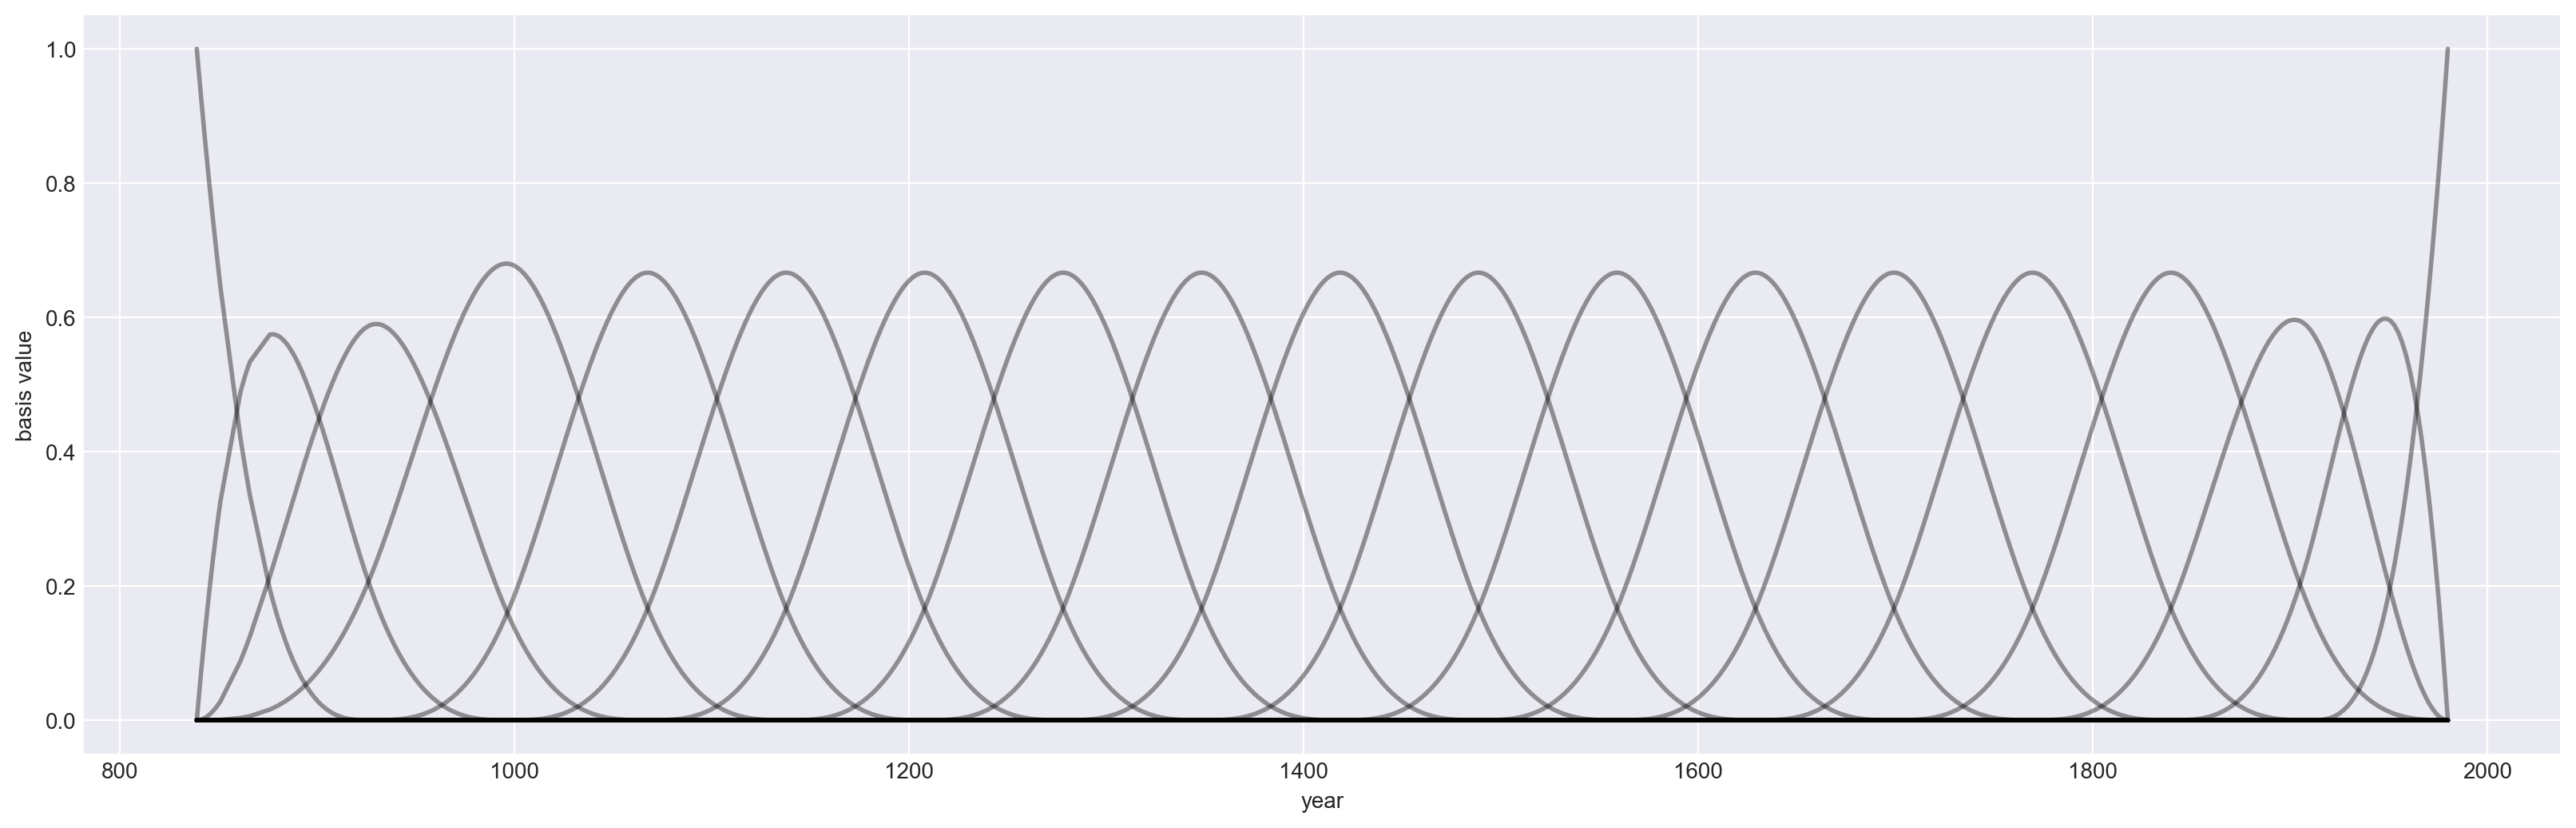

In [33]:
plt.figure(figsize=(20, 6))
for i in range(B.shape[1]):
    plt.plot(d2.year.values, B[:, i], color='black', alpha=0.4, linewidth=2)
plt.xlabel('year')
plt.ylabel('basis value');

#### Code 4.76

In [34]:
with pm.Model() as m4_7: 
    sigma = pm.Exponential('sigma', 1)
    w = pm.Normal('w', mu=0, sigma=3, shape=B.shape[1])
    a = pm.Normal('a', mu=100, sigma=5)
    mu = pm.Deterministic('mu', a + pm.math.dot(np.array(B), w))
    T = pm.Normal('T', mu=mu, sigma=sigma, observed=d2.temp.values)
    trace_m4_7 = pm.sample(1000, tune=100, cores = 1, chains = 4)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, w, a]


Output()

Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### Code 4.77

In [ ]:
year_seq = np.linspace(d2.year.min(), d2.year.max(), 1000)

B_seq = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": year_seq, "knots": knot_list},
)
B_seq_array = np.array(B_seq)

post = trace_m4_7.posterior
a_samples = post['a'].values.flatten()
w_samples = post['w'].values.reshape(-1, post['w'].shape[-1])  
sigma_samples = post['sigma'].values.flatten()

mu = a_samples[None, :] + B_seq_array @ w_samples.T

#### Code 4.78

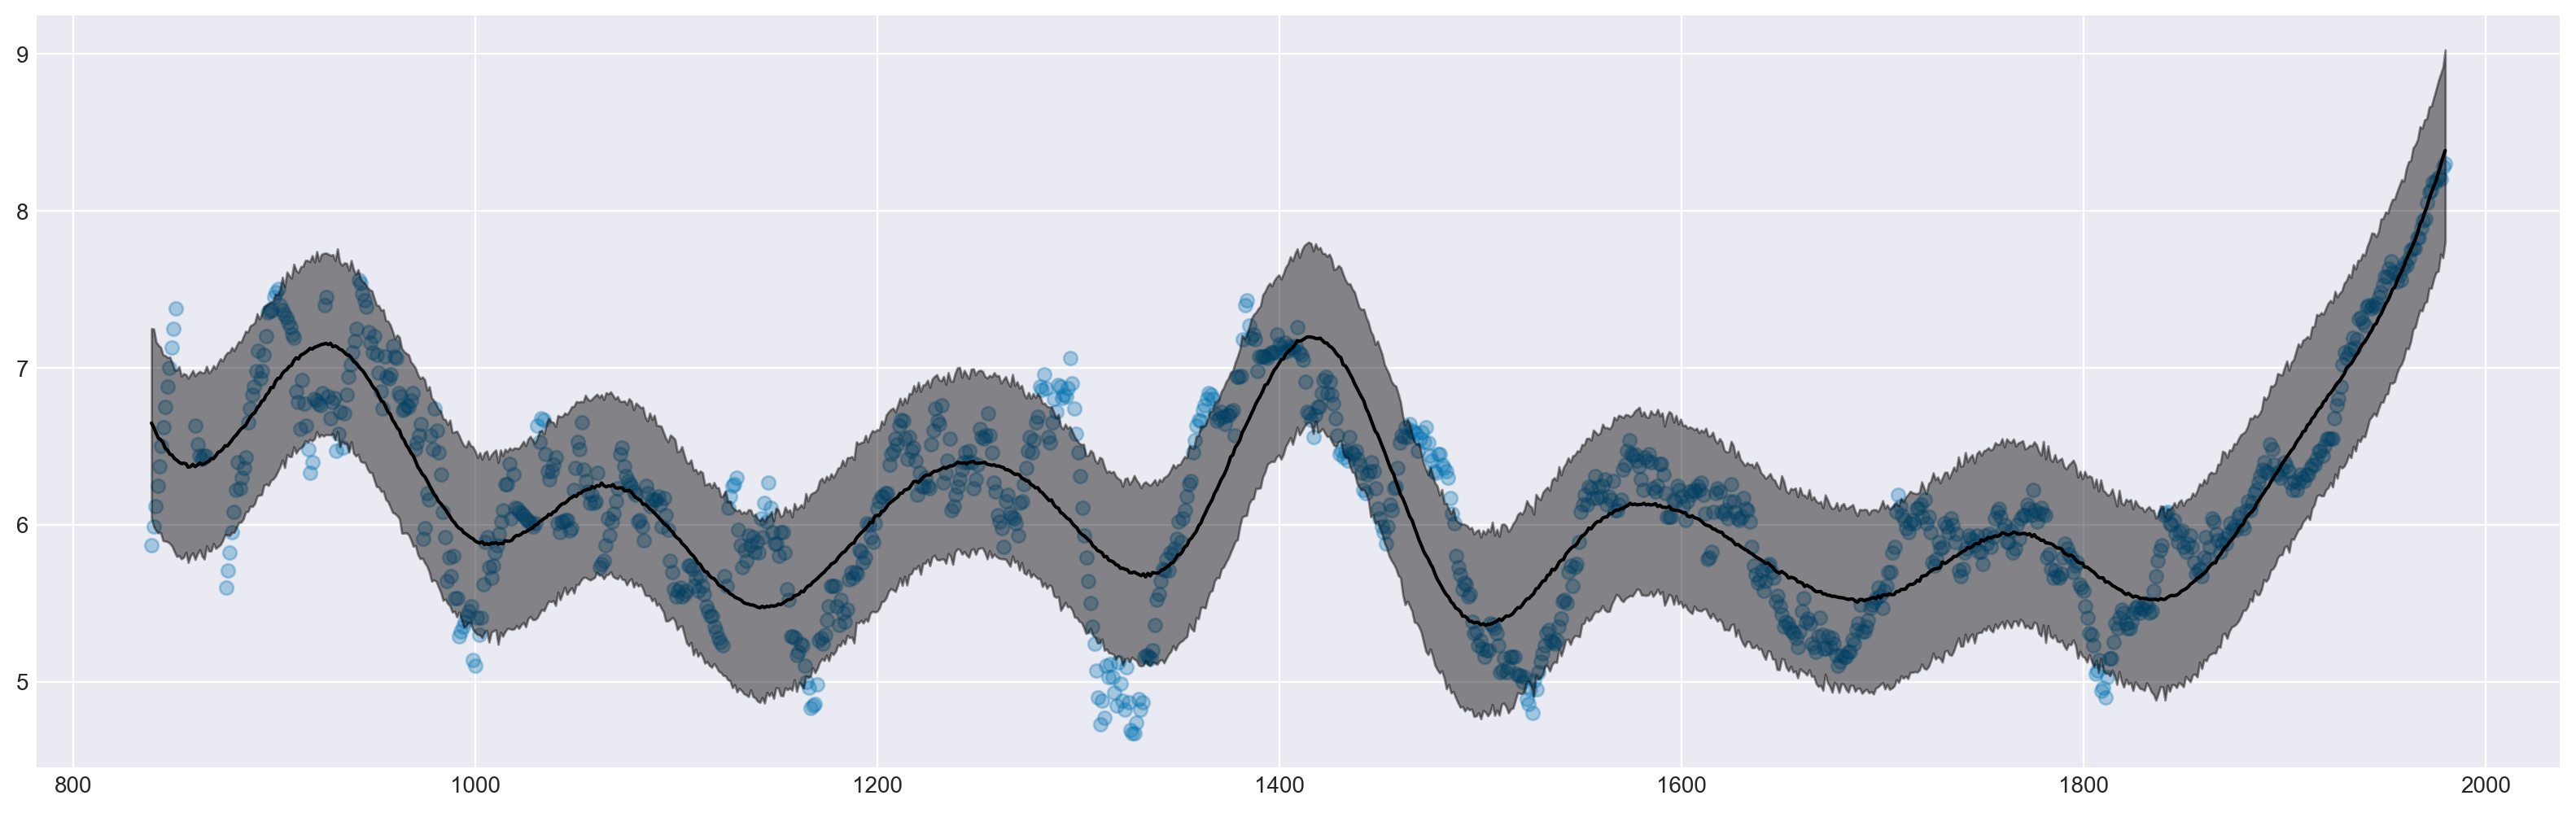

In [48]:
temp_pred = np.random.normal(mu, sigma_samples)  
temp_mean = temp_pred.mean(1)

temp_pi = np.array([az.hdi(temp_pred[i, :], hdi_prob=0.89) for i in range(len(year_seq))])

plt.figure(figsize=(20, 6))
plt.scatter(d2.year.values, d2.temp.values, c='C0', alpha=0.3);
plt.plot(year_seq, temp_mean, color='black');
plt.fill_between(year_seq, temp_pi[:,0], temp_pi[:,1], color='black', alpha=0.25)
plt.fill_between(year_seq, temp_pi[:,0], temp_pi[:,1], color='black', alpha=0.25);


#### Code 4.79

_This is largely a R situation.  There's not much need to be so explicit in the application of the matrix multiplication._